## **Lab 3:** Sampling, Aliasing, and Multiscale Representations


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, data, exposure, transform, filters, util, metrics, feature
import cv2
from scipy.signal import convolve2d
from scipy.ndimage import uniform_filter

import torch
import torch.nn.functional as F

print("Library versions:")
print("numpy:", np.__version__)
print("matplotlib:", plt.matplotlib.__version__)
print("cv2:", cv2.__version__)
print("pytorch:", torch.__version__)



Library versions:
numpy: 2.1.3
matplotlib: 3.10.1
cv2: 4.12.0
pytorch: 2.8.0+cu128


## 1. Introduction ##


Let's start by visually inspecting how different sampling rates (resolutions) affect image quality.

The below code systematically reduces an image's resolution by downsampling it to a fraction of its original size and then upsampling it back. This process visually demonstrates the irreversible loss of fine details (like the cat's whiskers or text strokes) as the sampling rate decreases.


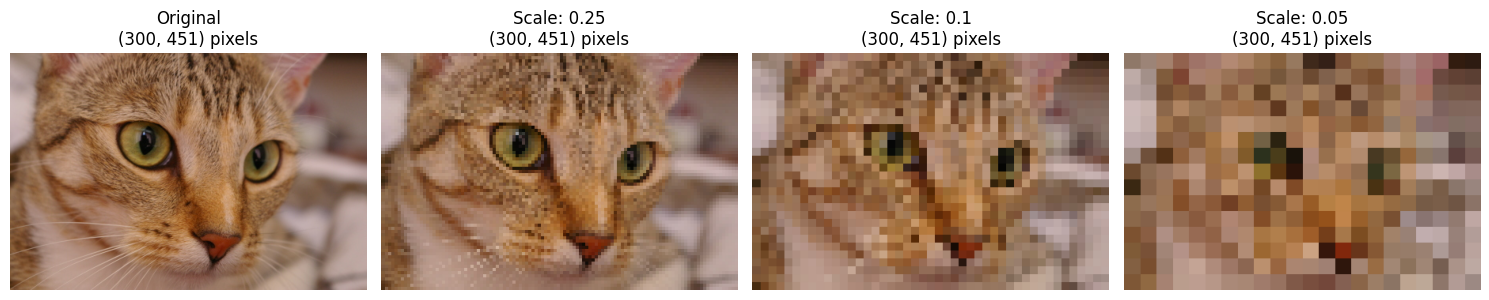

In [2]:
# Load a high-resolution image with fine details (like a face or text)
original_image = data.chelsea() # Or use data.text(), data.coins()

# Function to downsample and then upsample an image
def degrade_resolution(image, scale_factor):
    # Calculate new dimensions: Reduce resolution by scale_factor
    new_height = int(scale_factor*image.shape[0])
    new_width = int(scale_factor*image.shape[1])
    
    # Downsample: Shrink the image using nearest-neighbor interpolation
    small_image = cv2.resize(image,(new_width,new_height), interpolation=cv2.INTER_NEAREST)
    
    # Upsample: Enlarge the small image back to the original size
    # This reveals the loss of information from downsampling
    degraded_image = cv2.resize(small_image,(image.shape[1],image.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    return degraded_image

# Create a list of scaling factors to test
scale_factors = [1.0, 0.25, 0.1, 0.05]  # 100%, 25%, 10%, 5% of original resolution

# Create a plot to display the results
fig, axes = plt.subplots(1, len(scale_factors), figsize=(15, 5))

for i, scale in enumerate(scale_factors):
    if scale == 1.0:
        # For the first subplot, just show the original image
        axes[i].imshow(original_image)
        title_str = f'Original\n{original_image.shape[:2]} pixels'
    else:
        # For others, show the degraded version
        degraded_img = degrade_resolution(original_image, scale)
        axes[i].imshow(degraded_img)
        title_str = f'Scale: {scale}\n{degraded_img.shape[:2]} pixels'
    
    axes[i].set_title(title_str)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Reducing resolution is the simplest form of image compression. Let's quantify the data savings.

The below block calculates the raw data reduction achieved by lowering resolution. It shows that even a modest downsampling can reduce data size by over 90%, highlighting the trade off between file size and visual fidelity.


In [3]:
# Calculate and print the compression ratio and data saved
print("--- Compression Analysis ---")
original_pixels = original_image.shape[0] * original_image.shape[1]
print(f"Original image: {original_pixels} pixels")

for scale in scale_factors[1:]: # Skip the 1.0 scale
    # Calculate the number of pixels in the downsampled image
    small_height = original_image.shape[0]*scale
    small_width = original_image.shape[1]*scale
    small_pixels = small_width*small_height
    
    # Calculate compression ratio and data saved
    compression_ratio = original_pixels/small_pixels
    data_saved_percent = (1-(small_pixels/original_pixels))*100
    
    print(f"Scale {scale}:")
    print(f"  Pixels: {small_pixels}")
    print(f"  Compression Ratio: ~{compression_ratio:.1f}:1")
    print(f"  Data Saved: {data_saved_percent:.1f}%")
    print()

--- Compression Analysis ---
Original image: 135300 pixels
Scale 0.25:
  Pixels: 8456.25
  Compression Ratio: ~16.0:1
  Data Saved: 93.8%

Scale 0.1:
  Pixels: 1353.0
  Compression Ratio: ~100.0:1
  Data Saved: 99.0%

Scale 0.05:
  Pixels: 338.25
  Compression Ratio: ~400.0:1
  Data Saved: 99.8%



In [4]:
# Load a high-resolution image with clear edges and details
# original_image = data.chelsea()
# original_image = transform.rescale(original_image, 0.5)  # Smaller for faster computation

def build_gaussian_pyramid_with_residuals(image, max_level=4):
    """
    Build Gaussian pyramid and compute residuals between levels.
    
    Returns:
        pyramid: list of Gaussian pyramid levels
        residuals: list of detail lost between consecutive levels
    """
    pyramid = [image]  # Level 0 is the original image
    residuals = []     # Will store details lost between levels
    
    current_image = image
    
    for level in range(1, max_level):
        
        # Step 1: Apply Gaussian blur (anti-aliasing filter)
        blurred = filters.gaussian(current_image)
        
        # Step 2: Downsample by a factor of 2
        downsampled = transform.rescale(blurred, 0.5,anti_aliasing=False,channel_axis=2)
        
        # Step 3: Compute residual - detail lost during downsampling
        # Upsample back to previous level size to compare
        upsampled = transform.resize(downsampled, current_image.shape,anti_aliasing=False)
        residual = current_image-upsampled
        
        
        pyramid.append(downsampled)
        residuals.append(residual)
        current_image = downsampled
    
    return pyramid, residuals

# Build the pyramid with residuals
gaussian_pyramid, residuals = build_gaussian_pyramid_with_residuals(original_image, max_level=5)

print("Pyramid Statistics:")
for i, level in enumerate(gaussian_pyramid):
    print(f"Level {i}: {level.shape} - Size: {level.shape[0]}x{level.shape[1]}")

Pyramid Statistics:
Level 0: (300, 451, 3) - Size: 300x451
Level 1: (150, 226, 3) - Size: 150x226
Level 2: (75, 113, 3) - Size: 75x113
Level 3: (38, 56, 3) - Size: 38x56
Level 4: (19, 28, 3) - Size: 19x28


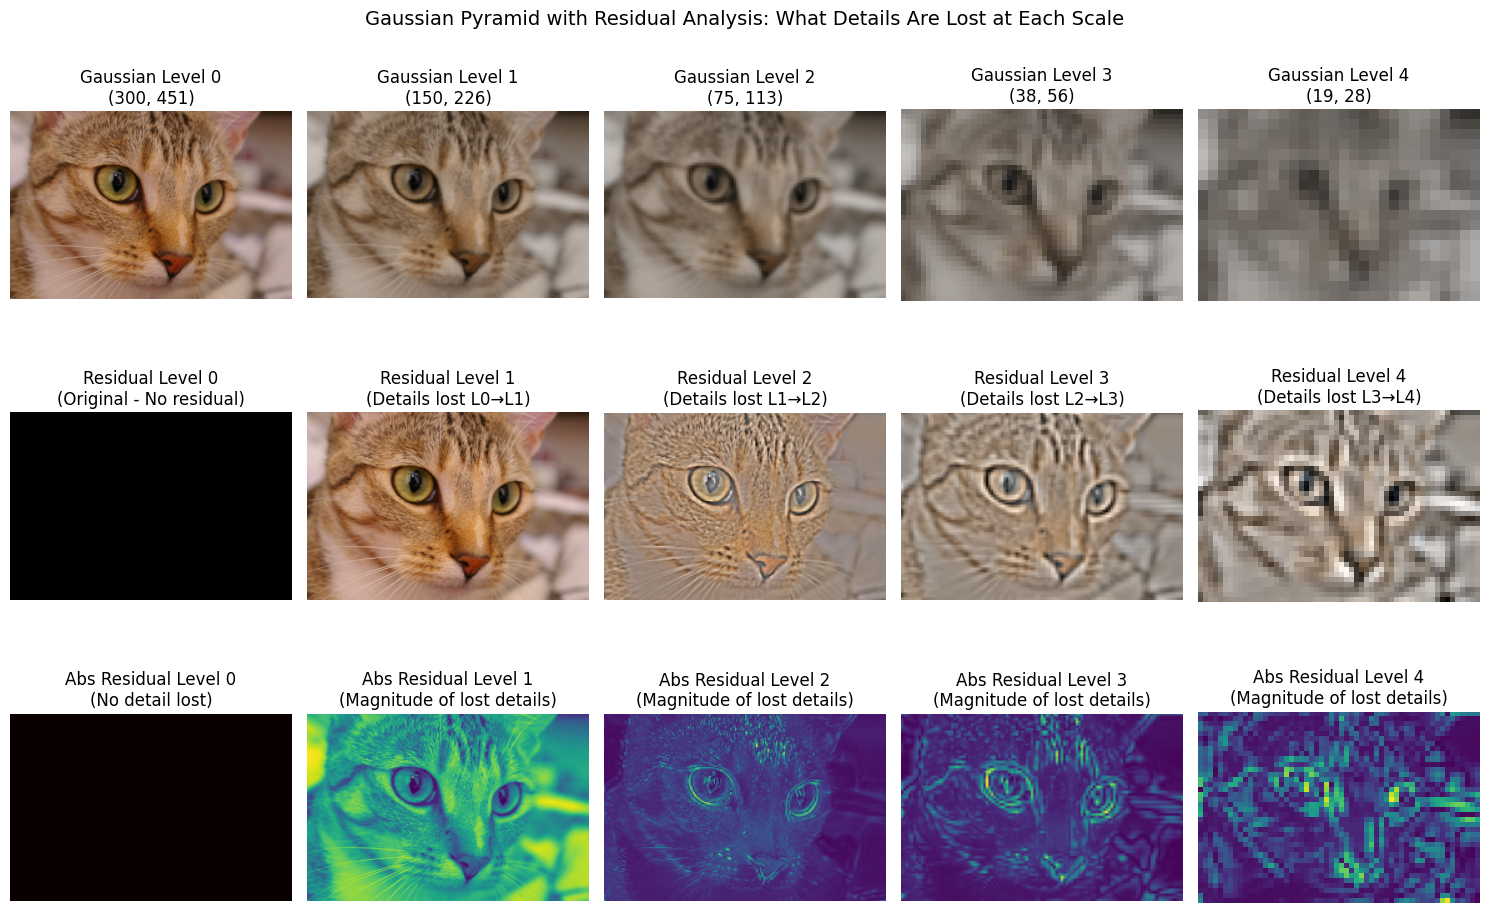

In [5]:
# Create comprehensive visualization
n_levels = len(gaussian_pyramid)
fig, axes = plt.subplots(3, n_levels, figsize=(15, 10))

# Row 1: Gaussian Pyramid Levels
for i in range(n_levels):
    axes[0, i].imshow(gaussian_pyramid[i])
    axes[0, i].set_title(f'Gaussian Level {i}\n{gaussian_pyramid[i].shape[:2]}')
    axes[0, i].axis('off')

# Row 2: Residuals (Details Lost)
for i in range(n_levels):
    if i == 0:
        # First level has no residual (it's the original)
        axes[1, i].imshow(np.zeros_like(gaussian_pyramid[i]))
        axes[1, i].set_title('Residual Level 0\n(Original - No residual)')
    else:
        # Display residual with enhanced contrast for visibility
        residual = residuals[i-1]
        
        # Normalize for better visualization
        residual_display = residual - np.min(residual)
        residual_display = residual_display/np.max(residual_display)
        
        axes[1, i].imshow(residual_display)
        axes[1, i].set_title(f'Residual Level {i}\n(Details lost L{i-1}→L{i})')
    axes[1, i].axis('off')

# Row 3: Residuals - Absolute Difference (emphasize magnitude)
for i in range(n_levels):
    if i == 0:
        axes[2, i].imshow(np.zeros_like(gaussian_pyramid[i][:, :, 0]), cmap='hot')
        axes[2, i].set_title('Abs Residual Level 0\n(No detail lost)')
    else:
        # Compute absolute residual magnitude across color channels
        residual_magnitude = np.mean(np.abs(residuals[i-1]),axis=2)
        axes[2, i].imshow(residual_magnitude)
        axes[2, i].set_title(f'Abs Residual Level {i}\n(Magnitude of lost details)')
    axes[2, i].axis('off')

plt.suptitle('Gaussian Pyramid with Residual Analysis: What Details Are Lost at Each Scale', fontsize=14)
plt.tight_layout()
plt.show()

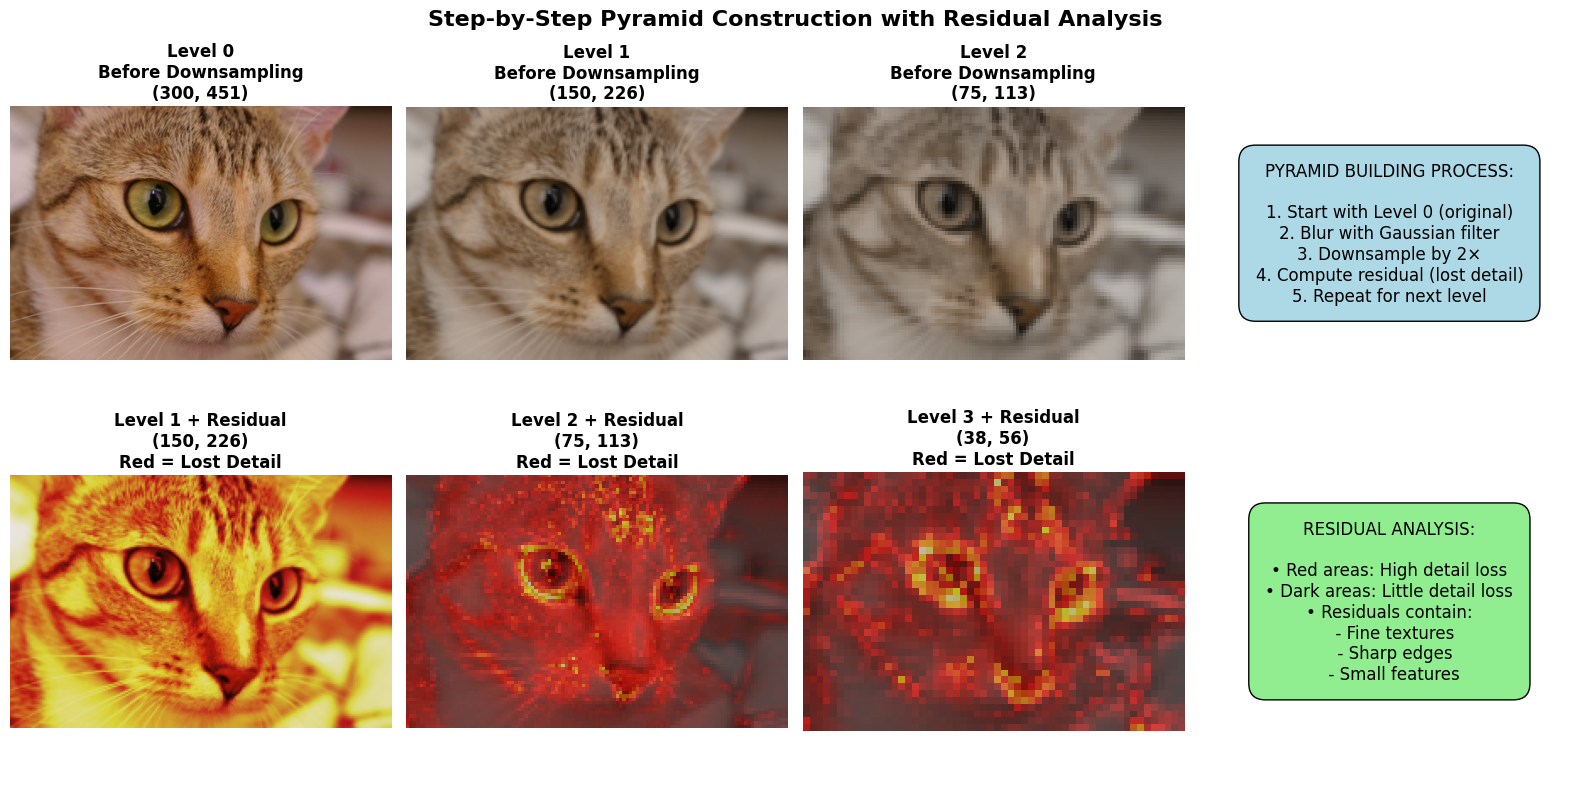

In [6]:
# Visualize the pyramid building process step by step
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Show the process for first two transitions in detail
for step in range(min(3, len(residuals))):
    # Left: Original level
    axes[0, step].imshow(gaussian_pyramid[step])
    axes[0, step].set_title(f'Level {step}\nBefore Downsampling\n{gaussian_pyramid[step].shape[:2]}', 
                          fontweight='bold')
    axes[0, step].axis('off')
    
    # Right: Residual lost + Next level
    residual = residuals[step]
    residual_magnitude = np.mean(np.abs(residual), axis=2)
    
    # Create a composite image showing residual overlay
    axes[1, step].imshow(gaussian_pyramid[step+1])
    # Overlay residual magnitude
    residual_resized = transform.resize(residual_magnitude, gaussian_pyramid[step+1].shape[:2])
    axes[1, step].imshow(residual_resized, cmap='hot', alpha=0.6)
    axes[1, step].set_title(f'Level {step+1} + Residual\n{gaussian_pyramid[step+1].shape[:2]}\nRed = Lost Detail', 
                          fontweight='bold')
    axes[1, step].axis('off')

# Add process description
axes[0, 3].text(0.5, 0.5, 'PYRAMID BUILDING PROCESS:\n\n1. Start with Level 0 (original)\n2. Blur with Gaussian filter\n3. Downsample by 2×\n4. Compute residual (lost detail)\n5. Repeat for next level', 
                ha='center', va='center', fontsize=12, 
                bbox=dict(boxstyle="round,pad=1", facecolor="lightblue"))
axes[0, 3].axis('off')

axes[1, 3].text(0.5, 0.5, 'RESIDUAL ANALYSIS:\n\n• Red areas: High detail loss\n• Dark areas: Little detail loss\n• Residuals contain:\n  - Fine textures\n  - Sharp edges\n  - Small features', 
                ha='center', va='center', fontsize=12,
                bbox=dict(boxstyle="round,pad=1", facecolor="lightgreen"))
axes[1, 3].axis('off')

plt.suptitle('Step-by-Step Pyramid Construction with Residual Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

- Row 1: Standard Gaussian pyramid from fine to coarse
- Row 2: Color residuals showing what details were lost (both positive and negative differences)
- Row 3: Magnitude of lost details, emphasizing where the most information was discarded


Through these exercises, we have seen that:

- **Resolution dictates information content**. Insufficient sampling (low resolution) leads to irretrievable loss of detail and introduces aliasing artifacts.

- **Compression is a trade-off**. Reducing resolution is a direct, if crude, method of compression, forcing a choice between fidelity and file size.

- **Vision is multiscale**. A single resolution is often insufficient for analysis. Pyramids and other multiscale representations provide a structured way to analyze an image across different levels of detail, mimicking a core principle of human and computer vision.


## 2. Sampling and Aliasing ##

Downsample an image without filtering $\rightarrow$ show aliasing artifacts. Compare with downsampling after Gaussian filtering.


Regular patterns are most susceptible to aliasing. Let's create a synthetic image to see this effect clearly.

The below code creates a high-frequency pattern and then demonstrates severe aliasing by downsampling it without any filtering. The regular pattern in the original image collapses into a distorted, low-frequency moiré pattern in the downsampled version.


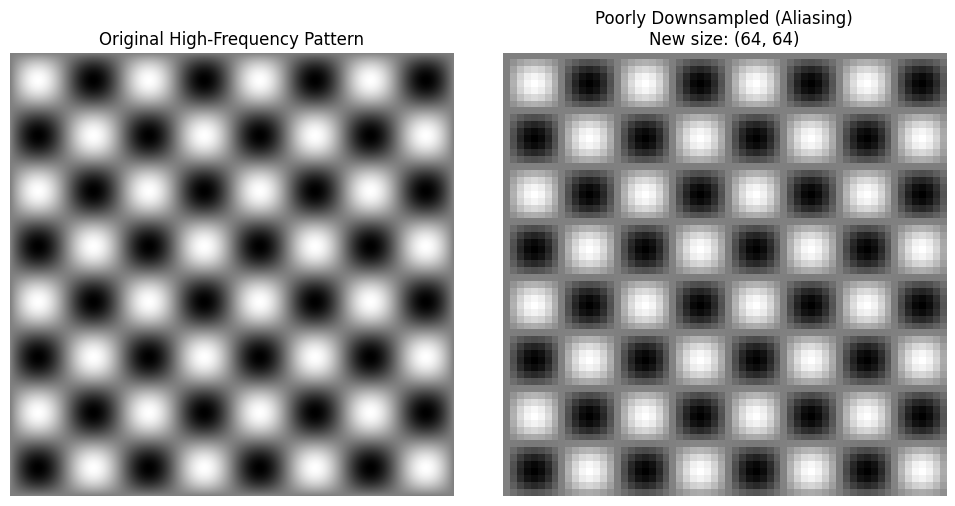

In [7]:
# Create a high-frequency sinusoidal pattern (like a fine stripe or checkerboard)
x = np.linspace(0, 8 * np.pi, 512)  # Create an array for 8 cycles
y = np.linspace(0, 8 * np.pi, 512)
X, Y = np.meshgrid(x, y)

# Generate a sine wave pattern - this is our high-frequency signal
high_freq_image = np.sin(X) * np.sin(Y)  # Creates a 2D checkerboard pattern

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(high_freq_image, cmap='gray')
plt.title('Original High-Frequency Pattern')
plt.axis('off')

# Now, let's downsample it poorly by taking every 8th pixel
downsampled_factor = 8
aliased_image = high_freq_image[::downsampled_factor,::downsampled_factor]

plt.subplot(1, 2, 2)
plt.imshow(aliased_image, cmap='gray', extent=[0, 512, 0, 512]) # 'extent' makes the image size comparable
plt.title(f'Poorly Downsampled (Aliasing)\nNew size: {aliased_image.shape}')
plt.axis('off')
plt.tight_layout()
plt.show()

Now let's apply this concept to a natural image. We will downsample by a factor of 4, first the wrong way (causing aliasing), and then the correct way (using an anti-aliasing filter).

The below code compares two downsampling methods on a natural image. The unfiltered method produces jagged edges and noisy textures (aliasing), while the method that uses a Gaussian filter first produces a cleaner, albeit smoother, result.


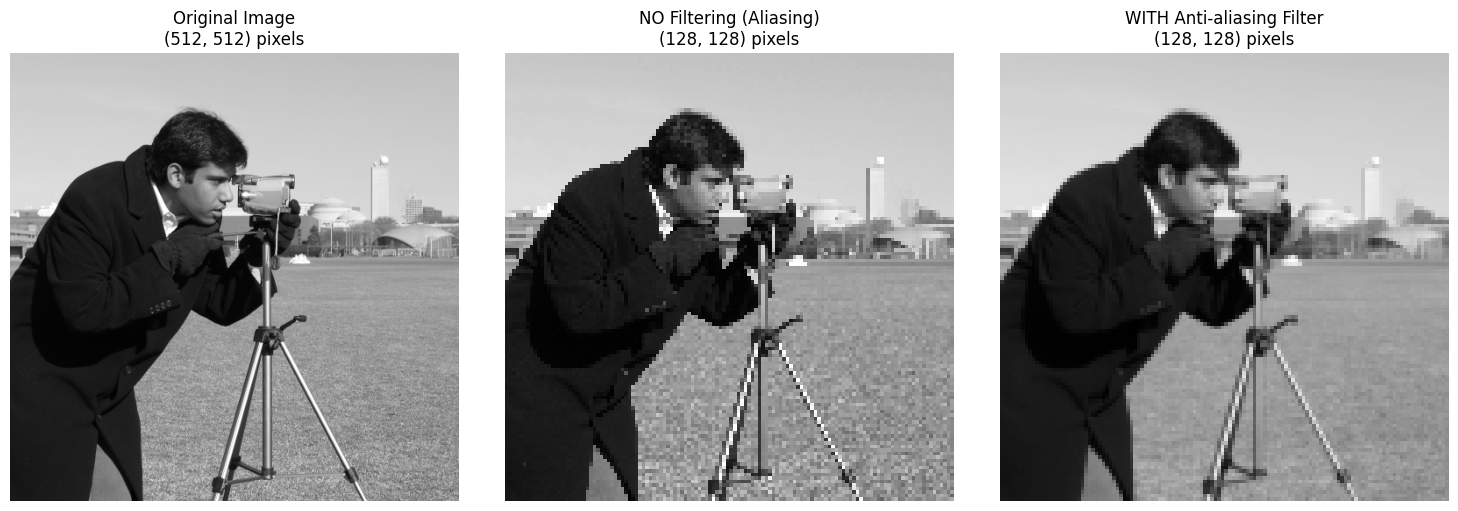

In [8]:
from scipy.ndimage import gaussian_filter

# Load a natural image with fine details and textures
natural_image = data.camera()  # A good image with high-frequency details like hair

downsample_factor = 4


# Method 1: Downsample WITHOUT anti-aliasing (The Wrong Way)
# Simply skip pixels. This is equivalent to using order=0 in resize.
downsampled_aliased = natural_image[::downsample_factor,::downsample_factor]

# Method 2: Downsample WITH anti-aliasing (The Correct Way)
# First, apply a Gaussian low-pass filter to blur the image and remove high frequencies.
# The sigma is chosen relative to the downsample factor to cut off frequencies above the new Nyquist limit.
sigma = downsample_factor / 3.0  # A common rule of thumb for Gaussian filter sigma
filtered_image = gaussian_filter(natural_image,sigma)

# Now, downsample the filtered image
downsampled_anti_aliased = filtered_image[::downsample_factor,::downsample_factor]


# Display the results for comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original Image
axes[0].imshow(natural_image, cmap='gray')
axes[0].set_title(f'Original Image\n{natural_image.shape} pixels')
axes[0].axis('off')

# Aliased Result
axes[1].imshow(downsampled_aliased, cmap='gray', extent=[0, natural_image.shape[1], 0, natural_image.shape[0]])
axes[1].set_title(f'NO Filtering (Aliasing)\n{downsampled_aliased.shape} pixels')
axes[1].axis('off')

# Anti-aliased Result
axes[2].imshow(downsampled_anti_aliased, cmap='gray', extent=[0, natural_image.shape[1], 0, natural_image.shape[0]])
axes[2].set_title(f'WITH Anti-aliasing Filter\n{downsampled_anti_aliased.shape} pixels')
axes[2].axis('off')

plt.tight_layout()
plt.show()

The aliasing artifacts are often subtle. Let's crop into a specific region to see the difference more clearly.

The below code zooms in on a detailed region (like the camera's hair or the subject's eye) to provide a magnified view of the aliasing artifacts (jaggies and noise) versus the clean, smoothed result from proper pre-filtering.


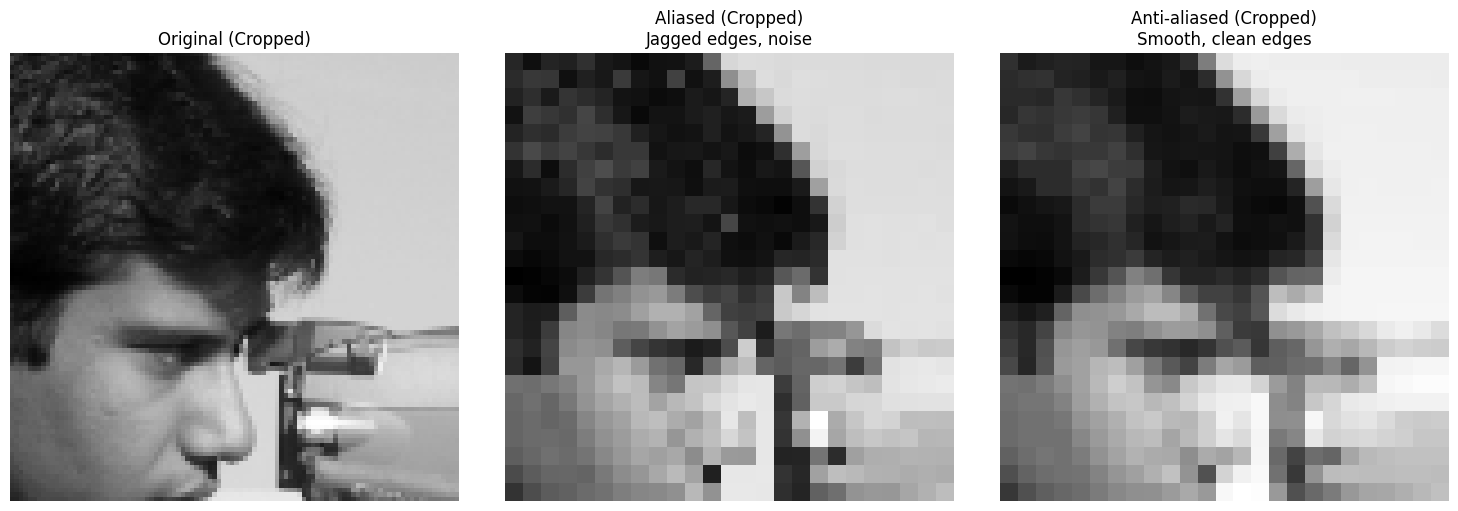

In [9]:
# Define a region of interest (ROI) to zoom in on, e.g., the eye or hair detail
# These coordinates might need adjustment based on the image you use.
y_start, y_end = 80, 180
x_start, x_end = 200, 300

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Crop and display the original region
axes[0].imshow(natural_image[y_start:y_end, x_start:x_end], cmap='gray')
axes[0].set_title('Original (Cropped)')
axes[0].axis('off')

# Crop and display the aliased region.
# Since the downsampled image is smaller, we must scale the crop coordinates accordingly.
aliased_crop = downsampled_aliased[y_start//downsample_factor:y_end//downsample_factor,x_start//downsample_factor:x_end//downsample_factor]
axes[1].imshow(aliased_crop, cmap='gray')
axes[1].set_title('Aliased (Cropped)\nJagged edges, noise')
axes[1].axis('off')

# Crop and display the anti-aliased region.
anti_aliased_crop = downsampled_anti_aliased[y_start//downsample_factor:y_end//downsample_factor,x_start//downsample_factor:x_end//downsample_factor]
axes[2].imshow(anti_aliased_crop, cmap='gray')
axes[2].set_title('Anti-aliased (Cropped)\nSmooth, clean edges')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 3. Upsampling and Interpolation ##

Nearest-neighbor vs bilinear vs bicubic interpolation. Visualise artifacts (blockiness, blurring).

After downsampling, we often need to enlarge an image again, a process known as **upsampling** or **image interpolation**. Unlike downsampling, which removes information, upsampling must create new pixel data. The method used to calculate these new pixel values—the interpolation algorithm—determines the quality of the enlarged image. Different algorithms make different trade-offs between sharpness, smoothness, and computational cost. In this section, we will compare the most common methods and their characteristic artifacts.

Key Concepts:

- **Interpolation**: The process of estimating unknown values between known data points.
- **Nearest-Neighbor**: Assigns the value of the closest pixel. Fast but creates blocky artifacts.
- **Bilinear**: Takes a weighted average of the 2x2 surrounding pixels. Smooths edges.
- **Bicubic**: Uses a more complex weighted average of the 4x4 surrounding pixels. Generally produces sharper results than bilinear but can introduce "ringing" artifacts.


To clearly see the effects of different interpolation methods, we will start with a severely downsampled image. This gives the interpolation algorithms a difficult task, making their differences obvious.


Original image shape: (300, 451, 3)
Low-res source shape: (30, 45, 3)


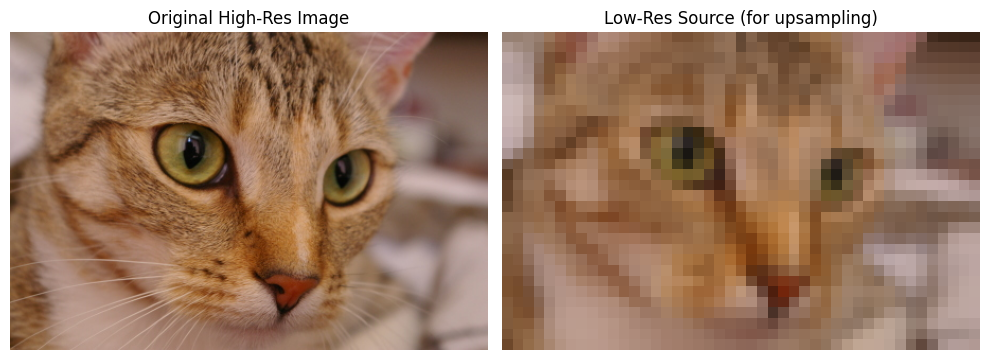

In [10]:
# Load a high-resolution image with clear edges and details
original_image = data.chelsea()

# Drastically downsample the image to create a low-resolution source
# We use a factor of 0.1 (10% of original size) to create a challenging upscaling task
downsample_factor = 0.1
low_res_image = transform.rescale(original_image,downsample_factor,anti_aliasing=True,channel_axis=2)

print(f"Original image shape: {original_image.shape}")
print(f"Low-res source shape: {low_res_image.shape}")

# Display the original and the low-res source
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(original_image)
axes[0].set_title('Original High-Res Image')
axes[0].axis('off')

axes[1].imshow(low_res_image)
axes[1].set_title('Low-Res Source (for upsampling)')
axes[1].axis('off')
plt.tight_layout()
plt.show()

Now, let's upsample our low-resolution image back to the original size using three different interpolation orders and compare the results.


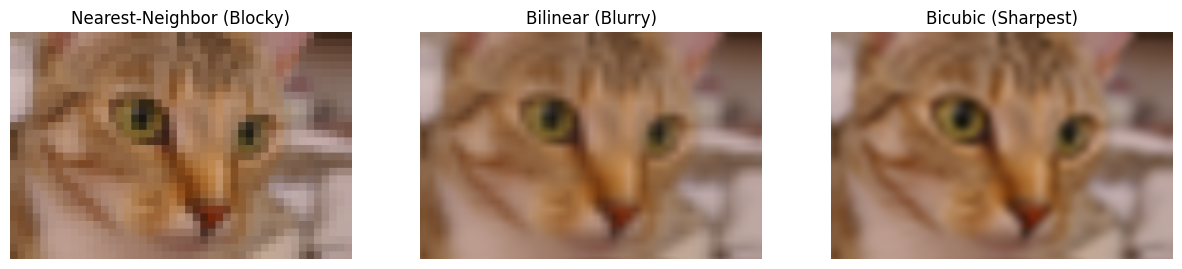

In [11]:
# Define the target size (the original image size)
target_shape = original_image.shape


# Method 1: Nearest-Neighbor Interpolation (order=0)
# Each new pixel takes the value of the closest pixel from the low-res image.
nn_upsampled = transform.resize(low_res_image, target_shape,order=0, anti_aliasing=False)

# Method 2: Bilinear Interpolation (order=1)
# New pixels are a weighted average of the 2x2 neighborhood of nearby pixels in the low-res image.
bilinear_upsampled = transform.resize(low_res_image, target_shape,order=1, anti_aliasing=False)

# Method 3: Bicubic Interpolation (order=3)
# New pixels are a weighted average of the 4x4 neighborhood. Generally produces smoother and sharper results.
bicubic_upsampled = transform.resize(low_res_image, target_shape,order=3, anti_aliasing=False)


# Create a comparison plot
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

# Display the full upsampled images
images = [nn_upsampled, bilinear_upsampled, bicubic_upsampled]
titles = ['Nearest-Neighbor (Blocky)', 'Bilinear (Blurry)', 'Bicubic (Sharpest)']

for i in range(3):
    axes[i].imshow(images[i])
    axes[i].set_title(titles[i])
    axes[i].axis('off')

- Nearest-Neighbor is the fastest but produces a blocky, pixelated result because it doesn't create new colors, just enlarges the existing blocks.

- Bilinear Interpolation is a good balance of speed and quality, smoothing out the blocks but also blurring genuine edges.

- Bicubic Interpolation is more computationally expensive but typically produces the most photorealistic enlargement by creating smoother gradients and sharper edges.


To really see the differences between methods, we need to zoom in on a detailed area.


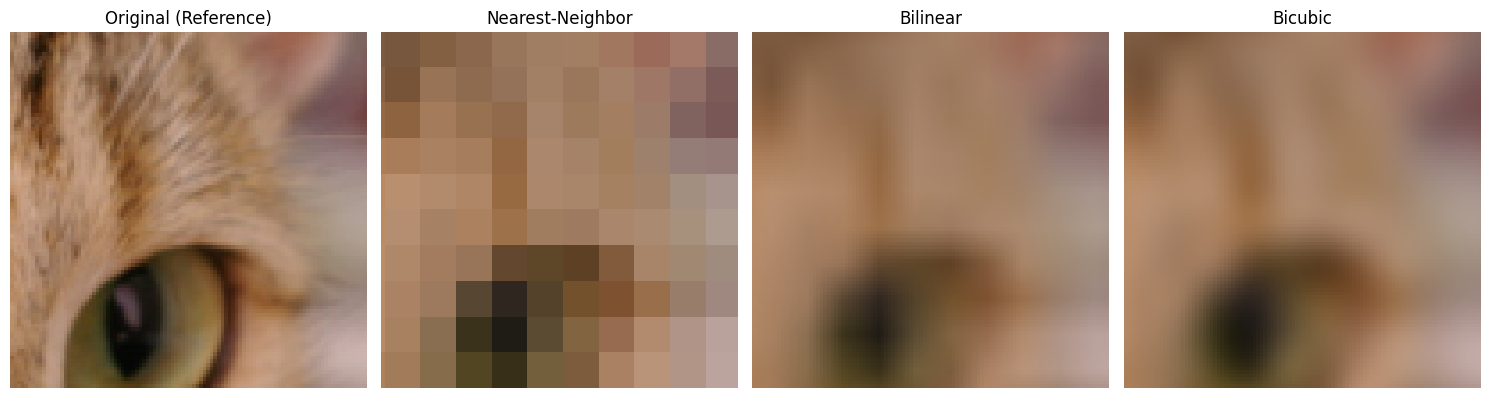

In [12]:
# Define a crop region on the original high-res image to compare details
# Let's get a region with an edge and some texture, like the cat's eye.
y_start, y_end = 50, 150
x_start, x_end = 280, 380

# Since we upsampled back to the original size, we can use the same crop coordinates for all images.
crops = [img[y_start:y_end, x_start:x_end] for img in [original_image, nn_upsampled, bilinear_upsampled, bicubic_upsampled]]
crop_titles = ['Original (Reference)', 'Nearest-Neighbor', 'Bilinear', 'Bicubic']

# Create a comparison plot
fig, axes = plt.subplots(1, 4, figsize=(15, 10))

# Display the cropped regions
for i in range(4):
    axes[i].imshow(crops[i])
    axes[i].set_title(crop_titles[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

While visual inspection is key, we can also compute a simple metric to quantify how different each upsampled result is from the original image.


In [13]:
# Calculate Mean Squared Error (MSE) between the original and each upsampled method.
def calculate_mse(original, reconstructed):
    mse = np.mean((original-reconstructed)**2)
    return mse

mse_nn = calculate_mse(original_image, nn_upsampled)
mse_bilinear = calculate_mse(original_image, bilinear_upsampled)
mse_bicubic = calculate_mse(original_image, bicubic_upsampled)

print("--- Mean Squared Error (MSE) Comparison ---")
print(f"Lower MSE indicates a closer match to the original.")
print(f"Nearest-Neighbor MSE: {mse_nn:.2f}")
print(f"Bilinear MSE:         {mse_bilinear:.2f}")
print(f"Bicubic MSE:          {mse_bicubic:.2f}")

--- Mean Squared Error (MSE) Comparison ---
Lower MSE indicates a closer match to the original.
Nearest-Neighbor MSE: 14966.36
Bilinear MSE:         14966.62
Bicubic MSE:          14966.19


- **Why Nearest-Neighbor can have lower MSE**: Nearest-Neighbor preserves the exact pixel values from the low-- resolution source at their original positions. Bilinear and Bicubic create new, "in-between" pixel values through averaging, which moves pixel values away from their original intensities, increasing the squared error.

- **MSE vs. Human Perception**: This result highlights a crucial limitation of MSE - it penalizes all differences equally, while human vision is more sensitive to certain types of errors (like blurry edges) than others.


## 4. Filter Banks ##

So far, we have processed images as a whole. Now, we will analyze them by breaking them down into their fundamental components: **features**. A filter bank is a collection of filters, each designed to detect a specific type of feature, such as edges at different orientations or textures at different scales. By applying a filter bank to an image, we create a set of **feature maps** (or **response maps**) that highlight where and how strongly each feature appears. This is the foundational concept behind many computer vision and deep learning systems.

Let's start by building a simple bank of filters to detect edges at different orientations. We will use Sobel filters, which are excellent for detecting horizontal and vertical gradients.


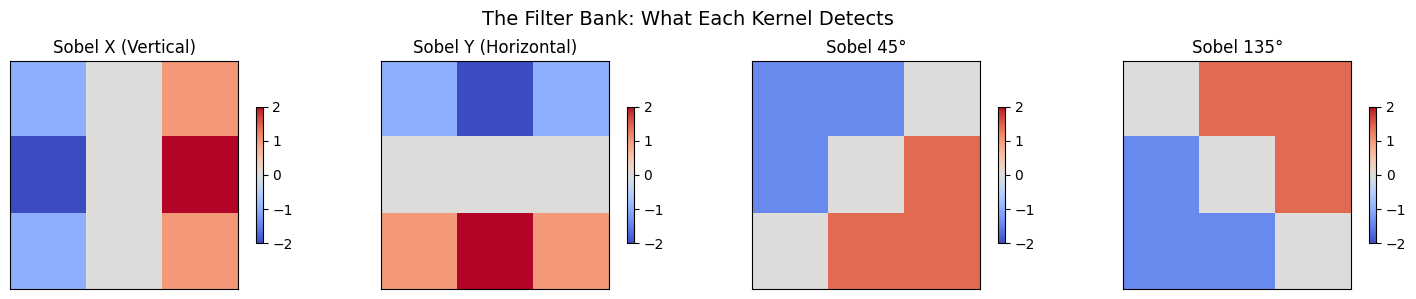

In [14]:
# Create a bank of Sobel filters for different edge orientations
# Sobel X: Detects vertical edges (high response where image intensity changes horizontally)
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

# Sobel Y: Detects horizontal edges (high response where image intensity changes vertically)
sobel_y = np.array([[-1, -2, -1],
                    [ 0,  0,  0],
                    [ 1,  2,  1]])


# We can create diagonal filters by combining X and Y components
# Sobel 45°: Detects edges at 45 degrees (top-left to bottom-right)
sobel_45 = (sobel_x + sobel_y)/np.sqrt(2)

# Sobel 135°: Detects edges at 135 degrees (top-right to bottom-left)
sobel_135 = (sobel_x - sobel_y)/np.sqrt(2)


# Assemble our filter bank
filter_bank = [sobel_x, sobel_y, sobel_45, sobel_135]
filter_names = ['Sobel X (Vertical)', 'Sobel Y (Horizontal)', 'Sobel 45°', 'Sobel 135°']

# Visualize the filters themselves
fig, axes = plt.subplots(1, len(filter_bank), figsize=(15, 3))
for i, (filt, name) in enumerate(zip(filter_bank, filter_names)):
    im = axes[i].imshow(filt, cmap='coolwarm', vmin=-2, vmax=2)
    axes[i].set_title(name)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    plt.colorbar(im, ax=axes[i], shrink=0.6)
plt.suptitle('The Filter Bank: What Each Kernel Detects', fontsize=14)
plt.tight_layout()
plt.show()

- The positive (red) and negative (blue) weights in the filters create a strong response when slid across an edge, where pixel intensities change rapidly.

- The central column of ```sobel_x``` is zero because it averages the left and right columns; a strong difference between them indicates a vertical edge.


Now, let's apply each filter in our bank to the image using convolution and examine the resulting feature maps.


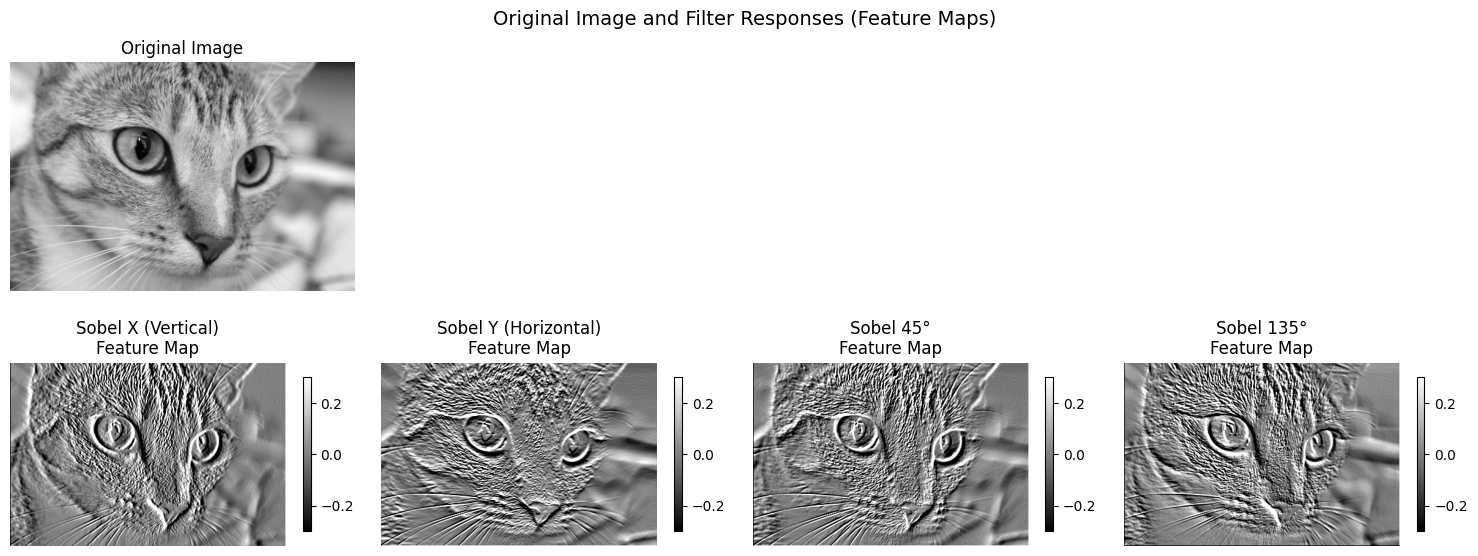

In [15]:
from scipy import ndimage

# Load a grayscale image for clearer filter responses
image = color.rgb2gray(data.chelsea())

# Apply each filter via convolution and store the resulting feature maps
feature_maps = []
for filt in filter_bank:
    # Convolve the image with the current filter
    # mode='constant' handles the image borders by padding with zeros
    feature_map = ndimage.convolve(image, filt, mode='constant')
    feature_maps.append(feature_map)

# Visualize the original image and all feature maps
fig, axes = plt.subplots(2, len(filter_bank), figsize=(15, 6))

# Display the original image
axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

# Display the feature maps for each filter
for i in range(1, len(filter_bank)):
    axes[0, i].axis('off') # Hide unused subplots in the first row

for i, (feature_map, name) in enumerate(zip(feature_maps, filter_names)):
    # Display the raw feature map
    im1 = axes[1, i].imshow(feature_map, cmap='gray', vmin=-0.3, vmax=0.3)
    axes[1, i].set_title(f'{name}\nFeature Map')
    axes[1, i].axis('off')
    plt.colorbar(im1, ax=axes[1, i], shrink=0.6)

plt.suptitle('Original Image and Filter Responses (Feature Maps)', fontsize=14)
plt.tight_layout()
plt.show()

- Bright (yellow) and dark (blue) regions in the feature maps indicate strong positive and negative responses, respectively, corresponding to edges in different directions.

- Notice how ```sobel_x``` strongly activates on the cat's vertical whiskers, while ```sobel_y``` activates on the horizontal lines of the mouth and eyes.


Features exist at different scales. A cat's fur has fine-scale texture, while its body outline is a large-scale edge. Let's create a filter bank that can detect features at multiple scales by using Gaussian derivatives.


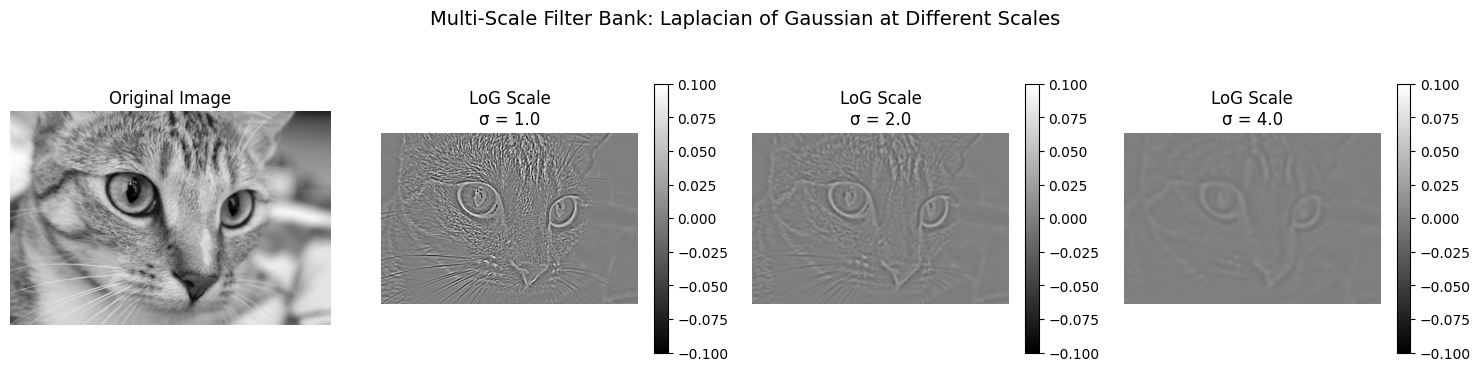

In [16]:
# Create a multi-scale filter bank using Laplacian of Gaussian (LoG)
# The Laplacian is a isotropic (rotation-invariant) edge detector.
# Combining it with a Gaussian (LoG) allows us to detect edges at a specific scale.

scales = [1.0, 2.0, 4.0]  # Sigma values for Gaussian blur - larger sigma = coarser scale
multi_scale_maps = []

for sigma in scales:
    # Apply Laplacian of Gaussian filter at the current scale
    # This filter responds strongly to edges and blobs at a scale proportional to sigma.
    log_response = ndimage.gaussian_laplace(image, sigma=sigma)
    multi_scale_maps.append(log_response)

# Visualize the multi-scale responses
fig, axes = plt.subplots(1, len(scales) + 1, figsize=(15, 4))

# Show original
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Show multi-scale feature maps
for i, (response, sigma) in enumerate(zip(multi_scale_maps, scales)):
    # Use a divergent colormap to show both positive and negative responses
    im = axes[i+1].imshow(response, cmap='gray', vmin=-0.1, vmax=0.1)
    axes[i+1].set_title(f'LoG Scale\nσ = {sigma}')
    axes[i+1].axis('off')
    plt.colorbar(im, ax=axes[i+1], shrink=0.8)

plt.suptitle('Multi-Scale Filter Bank: Laplacian of Gaussian at Different Scales', fontsize=14)
plt.tight_layout()
plt.show()

This code demonstrates a multi-scale filter bank using Laplacian of Gaussian (LoG) filters with different $\sigma$ (sigma) values. Smaller $\sigma$ detects fine details, while larger $\sigma$ detects larger, more blurred features.

- With sigma=1.0, the filter picks up fine details like individual whiskers and fur texture.

- With sigma=4.0, the filter responds only to the strongest, largest-scale edges like the cat's head outline and the boundary between its body and the background.


The true power of filter banks emerges when we interpret the collection of feature maps together. This provides a rich, multi-faceted description of the image content.


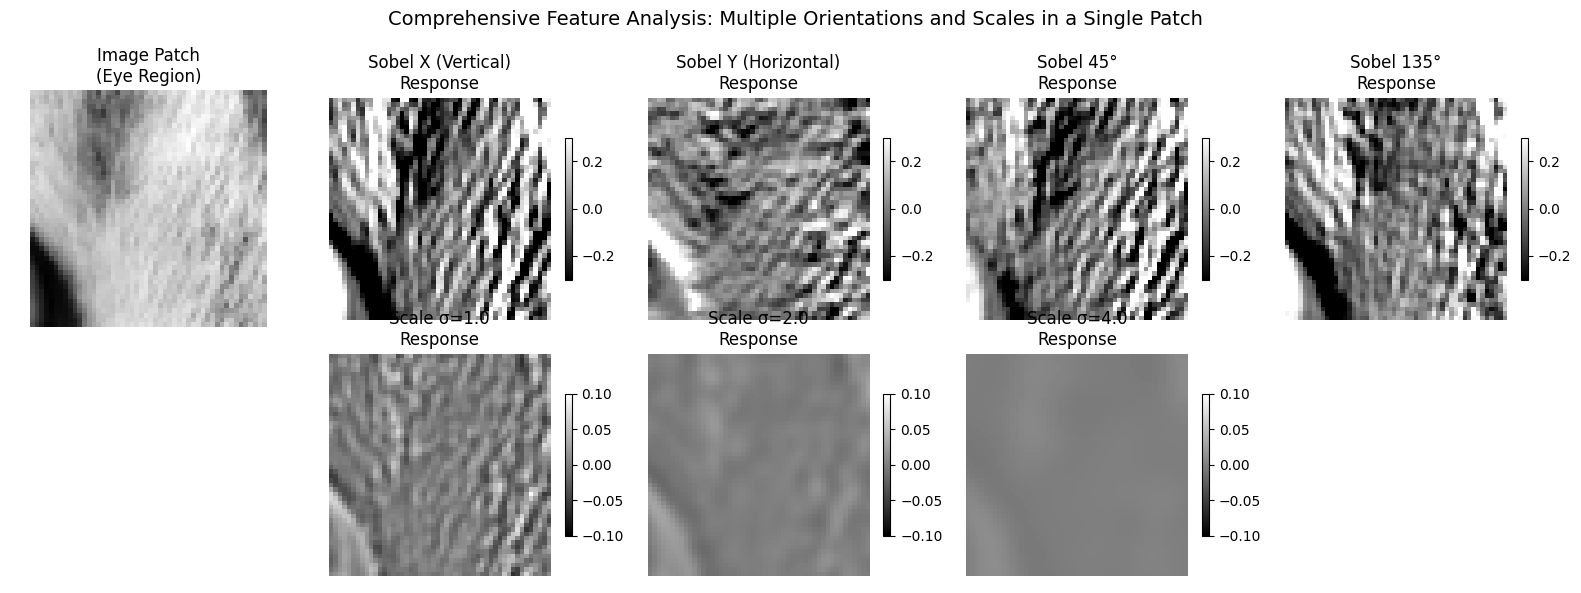

In [17]:
# Let's analyze a specific image patch by looking at all filter responses simultaneously
# Choose a patch that contains interesting structure (e.g., the cat's eye region)
patch_coords = (70, 120, 200, 250)  # y_start, y_end, x_start, x_end
y_start, y_end, x_start, x_end = patch_coords

# Create a comprehensive visualization
fig, axes = plt.subplots(2, 5, figsize=(16, 6))

# Show original patch
patch_original = image[y_start:y_end, x_start:x_end]
axes[0, 0].imshow(patch_original, cmap='gray')
axes[0, 0].set_title('Image Patch\n(Eye Region)')
axes[0, 0].axis('off')

# Show all orientation filter responses for this patch
for i, (feature_map, name) in enumerate(zip(feature_maps, filter_names)):
    patch_response = feature_map[y_start:y_end, x_start:x_end]
    im = axes[0, i+1].imshow(patch_response, cmap='gray', vmin=-0.3, vmax=0.3)
    axes[0, i+1].set_title(f'{name}\nResponse')
    axes[0, i+1].axis('off')
    plt.colorbar(im, ax=axes[0, i+1], shrink=0.6)

# Show multi-scale responses for the same patch
for i, (response, sigma) in enumerate(zip(multi_scale_maps, scales)):
    patch_response = response[y_start:y_end, x_start:x_end]
    im = axes[1, i+1].imshow(patch_response, cmap='gray', vmin=-0.1, vmax=0.1)
    axes[1, i+1].set_title(f'Scale σ={sigma}\nResponse')
    axes[1, i+1].axis('off')
    plt.colorbar(im, ax=axes[1, i+1], shrink=0.6)

# Hide the unused subplot
axes[1, 0].axis('off')
axes[1, 4].axis('off')

plt.suptitle('Comprehensive Feature Analysis: Multiple Orientations and Scales in a Single Patch', fontsize=14)
plt.tight_layout()
plt.show()

This code performs a detailed analysis of a specific image patch by examining its responses across all filters in both the orientation and scale banks, demonstrating how different features are captured by different filters.


## 5. Image Pyramids ##

Filter banks analyze an image at multiple scales but maintain full resolution for each analysis. **Image pyramids** take a different approach: they create a series of copies of the original image at progressively lower resolutions. This hierarchical representation is incredibly efficient and forms the foundation for many multiscale vision algorithms. The **Gaussian pyramid** provides a multiscale overview of the image content, while the **Laplacian pyramid** captures the detail lost between successive levels, enabling perfect image reconstruction.

Let's build a Gaussian pyramid by iteratively applying Gaussian smoothing and downsampling.


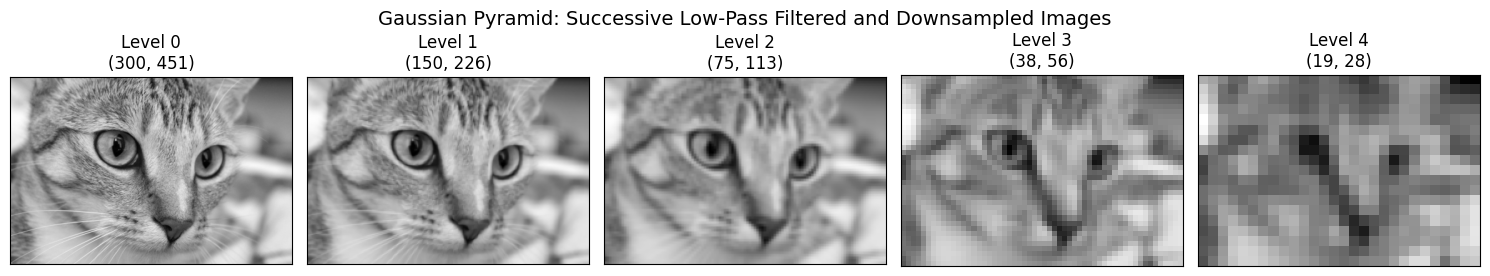

In [18]:
# Load and convert to grayscale for simplicity
image = color.rgb2gray(data.chelsea())
height, width = image.shape

def build_gaussian_pyramid(image, levels=4):
    """Build a Gaussian pyramid by iteratively blurring and downsampling."""
    pyramid = [image]  # Level 0 is the original image
    current_image = image
    
    for i in range(1, levels):
        # Step 1: Apply Gaussian blur to reduce high frequencies (anti-aliasing)
        # Sigma is chosen to match the reduction factor to prevent aliasing
        blurred = filters.gaussian(current_image)
        
        # Step 2: Downsample by a factor of 2 in each dimension
        # This reduces the image size to 1/4 of the previous level
        downsampled = transform.rescale(blurred, 0.5, anti_aliasing=False)
        
        pyramid.append(downsampled)
        current_image = downsampled
    
    return pyramid

# Build the pyramid
gaussian_pyramid = build_gaussian_pyramid(image, levels=5)

# Visualize the Gaussian pyramid
fig, axes = plt.subplots(1, len(gaussian_pyramid), figsize=(15, 3))

for i, level_img in enumerate(gaussian_pyramid):
    axes[i].imshow(level_img, cmap='gray')
    axes[i].set_title(f'Level {i}\n{level_img.shape}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.suptitle('Gaussian Pyramid: Successive Low-Pass Filtered and Downsampled Images', fontsize=14)
plt.tight_layout()
plt.show()

- The Gaussian blur with sigma=1.0 serves as an anti-aliasing filter before downsampling to prevent artifacts.
- Each level has 1/4 the pixels of the previous level, making the pyramid very efficient for storage and processing.


The Laplacian pyramid stores the details that are lost when building the Gaussian pyramid, enabling perfect reconstruction of the original image.


Mean Absolute Reconstruction Error: 0.0000000000
This should be very close to zero, demonstrating perfect reconstruction.


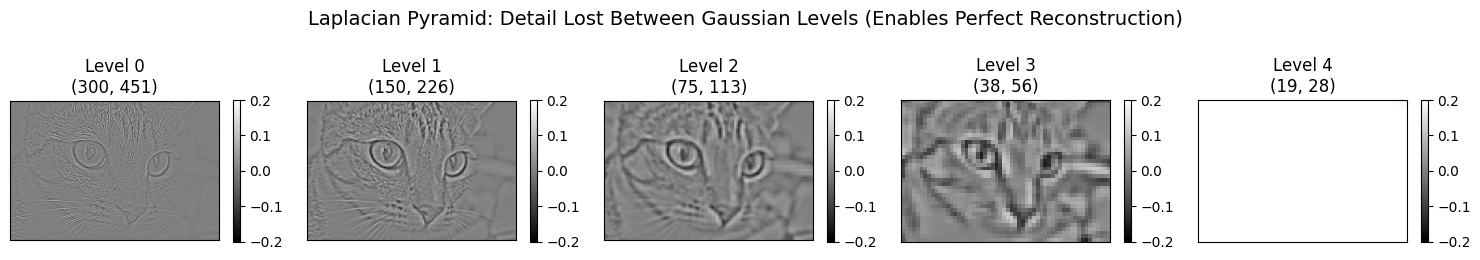

In [19]:
def build_laplacian_pyramid(gaussian_pyr):
    """Build a Laplacian pyramid from a Gaussian pyramid."""
    laplacian_pyr = []
    
    # For all levels except the last (smallest) one
    for i in range(len(gaussian_pyr) - 1):
        # Get the current Gaussian level
        g_current = gaussian_pyr[i]
        # Get the next (coarser) Gaussian level
        g_next = gaussian_pyr[i + 1]
        
        # Upsample the coarser level back to the current level's size
        g_next_upsampled = transform.resize(g_next, g_current.shape, order=1, preserve_range=True, anti_aliasing=False)
        
        # The Laplacian level is the difference between current level and upsampled coarser level
        # This captures the detail lost during downsampling
        laplacian = g_current-g_next_upsampled
        
        laplacian_pyr.append(laplacian)
    
    # The top of the Laplacian pyramid is the top of the Gaussian pyramid (lowest frequency content)
    laplacian_pyr.append(gaussian_pyr[-1])
    
    return laplacian_pyr

def reconstruct_from_laplacian_pyramid(laplacian_pyr):
    """Reconstruct the original image from its Laplacian pyramid."""
    # Start with the top level of the pyramid (lowest frequencies)
    reconstructed = laplacian_pyr[-1]
    
    # Reconstruct from top to bottom
    for i in range(len(laplacian_pyr) - 2, -1, -1):
        # Upsample the current reconstruction
        upsampled = transform.resize(reconstructed, laplacian_pyr[i].shape, order=1, preserve_range=True, anti_aliasing=False)
        # Add the Laplacian detail to recover the finer level
        reconstructed = laplacian_pyr[i]+upsampled
    
    return reconstructed

# Build both pyramids
gaussian_pyramid = build_gaussian_pyramid(image, levels=5)
laplacian_pyramid = build_laplacian_pyramid(gaussian_pyramid)

# Reconstruct the image from the Laplacian pyramid
reconstructed_image = reconstruct_from_laplacian_pyramid(laplacian_pyramid)

# Verify perfect reconstruction
reconstruction_error = np.mean(np.abs(image - reconstructed_image))
print(f"Mean Absolute Reconstruction Error: {reconstruction_error:.10f}")
print("This should be very close to zero, demonstrating perfect reconstruction.")

# Visualize the Laplacian pyramid
fig, axes = plt.subplots(1, len(laplacian_pyramid), figsize=(15, 3))

for i, level_img in enumerate(laplacian_pyramid):
    # Use divergent colormap to show both positive and negative differences
    im = axes[i].imshow(level_img, cmap='gray', vmin=-0.2, vmax=0.2)
    axes[i].set_title(f'Level {i}\n{level_img.shape}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    plt.colorbar(im, ax=axes[i], shrink=0.6)

plt.suptitle('Laplacian Pyramid: Detail Lost Between Gaussian Levels (Enables Perfect Reconstruction)', fontsize=14)
plt.tight_layout()
plt.show()

- The Laplacian levels contain both positive and negative values, representing details that were removed by blurring.

- The near-zero reconstruction error proves that the Laplacian pyramid is a **lossless** representation - all information is preserved despite the multiscale decomposition.


Pyramids enable seamless image blending by combining different frequency bands at different scales. This is the classic technique used for creating "orapple" (orange + apple) images.


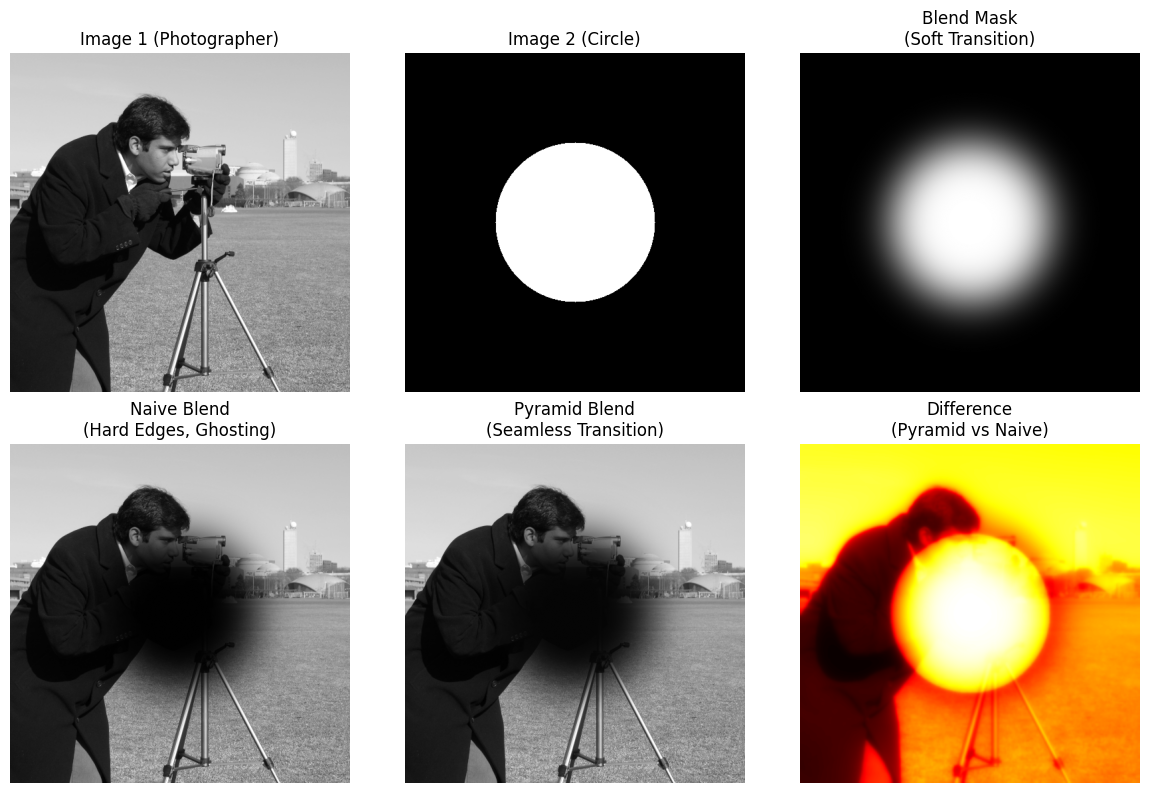

In [20]:
# Load two images to blend
image1 = data.camera()  # Photographer image
# Create a simple second image - a white circle on black background
y, x = np.ogrid[:512, :512]
center = (256, 256)
radius = 120
mask = (x - center[0])**2 + (y - center[1])**2 <= radius**2
image2 = mask.astype(float)

# Build pyramids for both images and the mask
levels = 6
gauss1 = build_gaussian_pyramid(image1, levels)
gauss2 = build_gaussian_pyramid(image2, levels)

# Create a Gaussian pyramid for the blend mask (soft transition)
blend_mask = filters.gaussian(mask.astype(float), sigma=30)  # Soft-edged mask
gauss_mask = build_gaussian_pyramid(blend_mask, levels)

# Blend at each pyramid level
blended_pyramid = []
for i in range(levels):
    # Weighted combination at current level: image1*(1-mask) + image2*mask
    blended_level = (gauss2[i]*gauss_mask[i])+gauss1[i] * (1-gauss_mask[i])
    blended_pyramid.append(blended_level)

# Reconstruct the final blended image from the blended Gaussian pyramid
# We can treat the blended pyramid as a Gaussian pyramid and build its Laplacian counterpart
final_blended = reconstruct_from_laplacian_pyramid(blended_pyramid)

# Compare with naive blending (direct pixel-wise combination)
naive_blend = image1*(1-blend_mask) + image2*blend_mask

# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

axes[0, 0].imshow(image1, cmap='gray')
axes[0, 0].set_title('Image 1 (Photographer)')
axes[0, 0].axis('off')

axes[0, 1].imshow(image2, cmap='gray')
axes[0, 1].set_title('Image 2 (Circle)')
axes[0, 1].axis('off')

axes[0, 2].imshow(blend_mask, cmap='gray')
axes[0, 2].set_title('Blend Mask\n(Soft Transition)')
axes[0, 2].axis('off')

axes[1, 0].imshow(naive_blend, cmap='gray')
axes[1, 0].set_title('Naive Blend\n(Hard Edges, Ghosting)')
axes[1, 0].axis('off')

axes[1, 1].imshow(final_blended, cmap='gray')
axes[1, 1].set_title('Pyramid Blend\n(Seamless Transition)')
axes[1, 1].axis('off')

# Show the difference
difference = np.abs(naive_blend - final_blended)
axes[1, 2].imshow(difference, cmap='hot')
axes[1, 2].set_title('Difference\n(Pyramid vs Naive)')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

- The Gaussian pyramid of the blend mask ensures that coarse-scale structures are blended over broader regions while fine details are blended locally.

- Pyramid blending works because it respects the scale-space nature of images - large features should transition smoothly, while small textures can change abruptly.


Laplacian pyramids have natural compression properties since most detail coefficients are near zero and can be quantized or discarded.


Level 0: 60989/135300 non-zero coefficients (ratio: 2.2:1)
Level 1: 17241/33900 non-zero coefficients (ratio: 2.0:1)
Level 2: 5286/8475 non-zero coefficients (ratio: 1.6:1)
Level 3: 1618/2128 non-zero coefficients (ratio: 1.3:1)
Level 4: 532/532 non-zero coefficients (ratio: 1.0:1)
Level 0: 9510/135300 non-zero coefficients (ratio: 14.2:1)
Level 1: 1968/33900 non-zero coefficients (ratio: 17.2:1)
Level 2: 774/8475 non-zero coefficients (ratio: 10.9:1)
Level 3: 422/2128 non-zero coefficients (ratio: 5.0:1)
Level 4: 532/532 non-zero coefficients (ratio: 1.0:1)
Level 0: 1012/135300 non-zero coefficients (ratio: 133.7:1)
Level 1: 154/33900 non-zero coefficients (ratio: 220.1:1)
Level 2: 88/8475 non-zero coefficients (ratio: 96.3:1)
Level 3: 48/2128 non-zero coefficients (ratio: 44.3:1)
Level 4: 532/532 non-zero coefficients (ratio: 1.0:1)


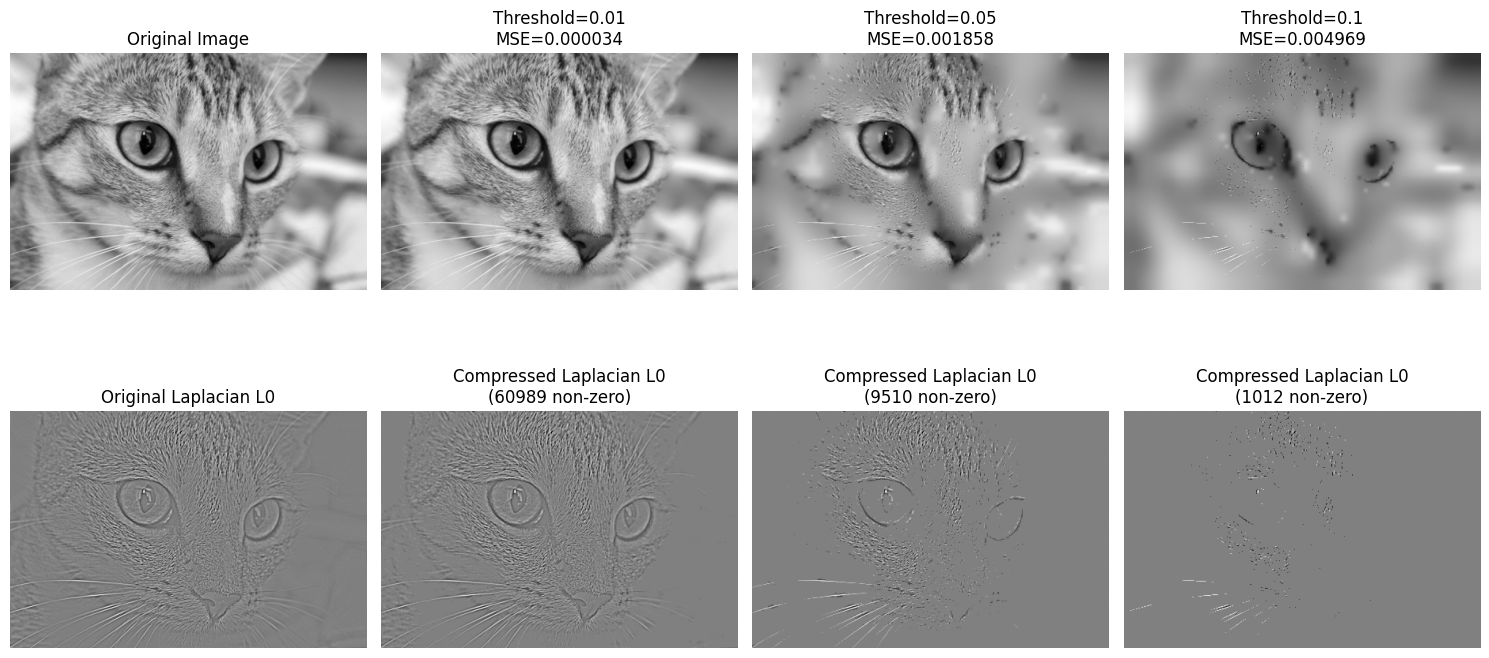

In [21]:
def compress_laplacian_pyramid(laplacian_pyr, threshold=0.05):
    """Compress Laplacian pyramid by thresholding small coefficients."""
    compressed_pyr = []
    for i, level in enumerate(laplacian_pyr):
        # Set small coefficients (< threshold) to zero (lossy compression)
        compressed_level = level*(np.abs(level)>=threshold)
        compressed_pyr.append(compressed_level)
        
        # Calculate compression statistics
        original_nonzero = np.count_nonzero(level)   # count nonzero (level)
        compressed_nonzero = np.count_nonzero(compressed_level) # count nonzero (compressed_level)
        compression_ratio = original_nonzero / max(compressed_nonzero, 1)
        print(f"Level {i}: {compressed_nonzero}/{original_nonzero} non-zero coefficients "
              f"(ratio: {compression_ratio:.1f}:1)")
    
    return compressed_pyr

# Test different compression thresholds
thresholds = [0.01, 0.05, 0.1]
fig, axes = plt.subplots(2, len(thresholds) + 1, figsize=(15, 8))

# Show original
axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

axes[1, 0].imshow(laplacian_pyramid[0], cmap='gray', vmin=-0.2, vmax=0.2)
axes[1, 0].set_title('Original Laplacian L0')
axes[1, 0].axis('off')

for i, threshold in enumerate(thresholds):
    # Compress and reconstruct
    compressed_pyr = compress_laplacian_pyramid(laplacian_pyramid, threshold=threshold) # compress_laplacian_pyramid()
    reconstructed = reconstruct_from_laplacian_pyramid(compressed_pyr)  # reconstruct_from_laplacian_pyramid()
    
    # Calculate metrics
    mse = np.mean((image - reconstructed) ** 2)
    
    # Display results
    axes[0, i+1].imshow(reconstructed, cmap='gray')
    axes[0, i+1].set_title(f'Threshold={threshold}\nMSE={mse:.6f}')
    axes[0, i+1].axis('off')
    
    axes[1, i+1].imshow(compressed_pyr[0], cmap='gray', vmin=-0.2, vmax=0.2)
    axes[1, i+1].set_title(f'Compressed Laplacian L0\n({np.count_nonzero(compressed_pyr[0])} non-zero)')
    axes[1, i+1].axis('off')

plt.tight_layout()
plt.show()

- Most detail coefficients in higher pyramid levels are very small and can be discarded with minimal visual impact.

- This demonstrates the sparse nature of Laplacian pyramids - most information is concentrated in a few significant coefficients, which is the principle behind modern compression methods like JPEG.


## 6. Exercises ##

- Implement your own pyramid without library shortcuts. 
- Blend two images seamlessly with Laplacian pyramids. 
- Explore aliasing in video downsampling. 
- Application to Textons.


Now that you understand the theory behind image pyramids, it's time to build them from the ground up! This will deepen your understanding of the core operations: convolution, downsampling, and upsampling. By implementing these functions manually, I'll gain valuable insights into what happens "under the hood" of library functions.

Implement Gaussian and Laplacian pyramids using only basic NumPy operations and custom convolution functions.


##### Implement Basic Convolution


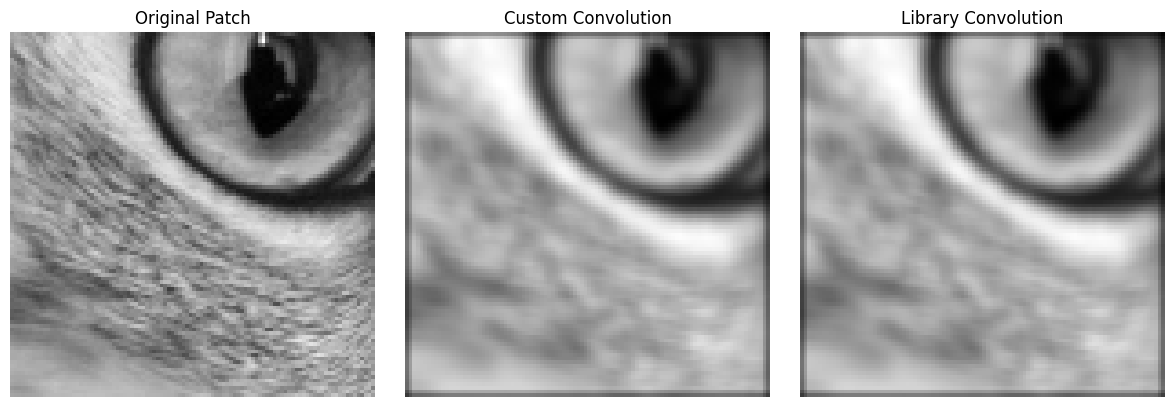

Maximum difference from library implementation: 0.0000000000


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color

def my_conv2d(image, kernel):
    """
    Implement 2D convolution with zero-padding.
    
    Args:
        image: 2D numpy array (grayscale image)
        kernel: 2D numpy array (odd dimensions, e.g., 3x3, 5x5)
    
    Returns:
        convolved: 2D numpy array of same spatial dimensions as input image
    """
    # Get dimensions
    img_h, img_w = image.shape
    kernel_h, kernel_w = kernel.shape
    
    # Calculate padding needed to maintain spatial dimensions
    pad_h = kernel_h // 2
    pad_w = kernel_w // 2
    
    # Create padded image with zeros around borders
    padded_image = np.pad(image,((pad_h, pad_h),(pad_w, pad_w)))
    
    # Initialize output array
    output = np.zeros_like(image)
    
    # Perform convolution
    for i in range(img_h):
        for j in range(img_w):
            # Extract the region of interest from padded image
            region = padded_image[i:i+kernel_h,j:j+kernel_w]
            # Compute element-wise multiplication and sum
            output[i, j] = np.sum(region*kernel[::-1,::-1])
    
    return output

# Test our convolution function with a simple blur kernel
test_image = color.rgb2gray(data.chelsea())[100:200, 100:200]  # Small patch for testing
blur_kernel = np.ones((5, 5)) / 25  # Simple averaging filter

# Apply our custom convolution
custom_result = my_conv2d(test_image, blur_kernel)

# Compare with scipy's convolution for validation
from scipy import ndimage
library_result = ndimage.convolve(test_image, blur_kernel, mode='constant')

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(test_image, cmap='gray')
axes[0].set_title('Original Patch')
axes[0].axis('off')

axes[1].imshow(custom_result, cmap='gray')
axes[1].set_title('Custom Convolution')
axes[1].axis('off')

axes[2].imshow(library_result, cmap='gray')
axes[2].set_title('Library Convolution')
axes[2].axis('off')

plt.tight_layout()
plt.show()

max_difference = np.max(np.abs(custom_result - library_result))
print(f"Maximum difference from library implementation: {max_difference:.10f}")

##### Implement Gaussian Blur with Custom Kernel


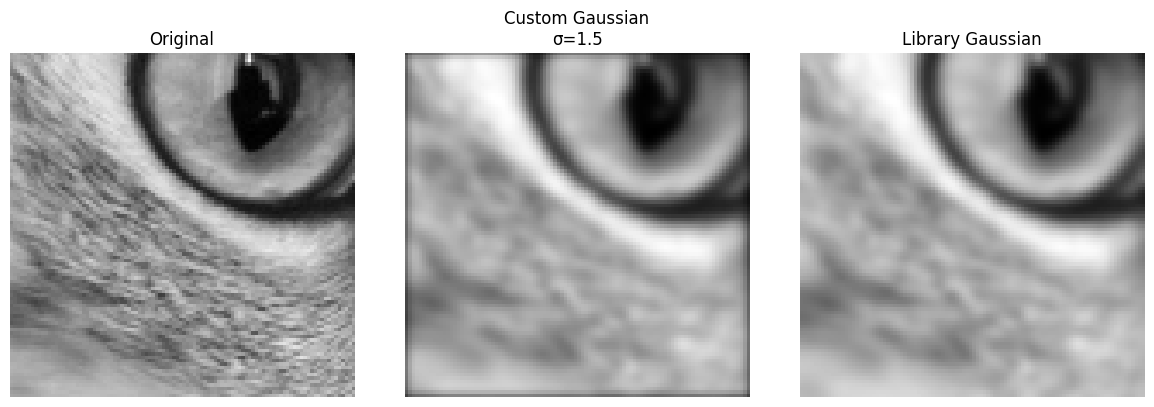

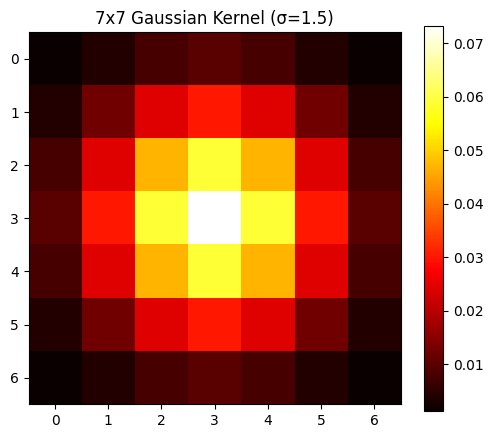

In [23]:
def create_gaussian_kernel(size=5, sigma=1.0):
    """
    Create a 2D Gaussian kernel.
    
    Args:
        size: kernel dimensions (size x size), should be odd
        sigma: standard deviation of Gaussian distribution
    
    Returns:
        kernel: 2D numpy array with Gaussian weights
    """
    # Create coordinate ranges
    ax = np.arange(-(size//2),(size//2)+1)
    xx, yy = np.meshgrid(ax,ax) # create meshgrids for interpolation
    # Compute 2D Gaussian
    kernel = np.exp(-(xx**2+yy**2)/(2*sigma**2))
    
    # Normalize so kernel sums to 1
    kernel = kernel / np.sum(kernel)
    
    return kernel

def my_gaussian_blur(image, sigma=1.0):
    """
    Apply Gaussian blur using our custom convolution.
    
    Args:
        image: 2D numpy array (grayscale image)
        sigma: standard deviation for Gaussian blur
    
    Returns:
        blurred: Gaussian-blurred image
    """
    # Create Gaussian kernel (using 3*sigma rule for kernel size)
    kernel_size = (6*sigma +1)  # Ensure odd size
    gaussian_kernel = create_gaussian_kernel(kernel_size,sigma)
    
    # Apply convolution with our custom function
    blurred = my_conv2d(image, gaussian_kernel)
    
    return blurred

# Test our Gaussian blur
test_sigma = 1.5
custom_blurred = my_gaussian_blur(test_image, sigma=test_sigma)
library_blurred = ndimage.gaussian_filter(test_image, sigma=test_sigma)

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(test_image, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(custom_blurred, cmap='gray')
axes[1].set_title(f'Custom Gaussian\nσ={test_sigma}')
axes[1].axis('off')

axes[2].imshow(library_blurred, cmap='gray')
axes[2].set_title('Library Gaussian')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Show the Gaussian kernel we created
gaussian_kernel = create_gaussian_kernel(7, test_sigma)
plt.figure(figsize=(6, 5))
plt.imshow(gaussian_kernel, cmap='hot')
plt.title(f'7x7 Gaussian Kernel (σ={test_sigma})')
plt.colorbar()
plt.show()

##### Implement Custom Downsampling and Upsampling


Original shape: (100, 100)
Downsampled shape: (50, 50)
Upsampled shape: (100, 100)


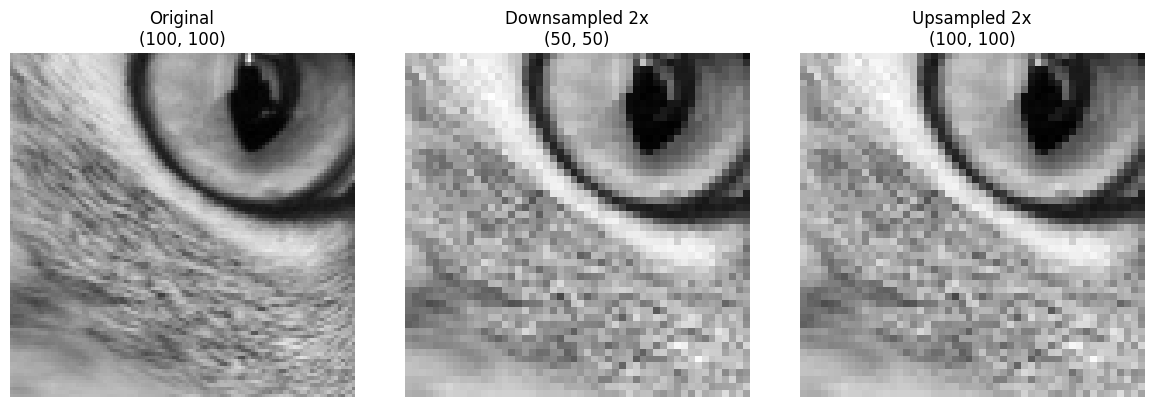

In [24]:
def my_downsample(image, factor=2):
    """
    Downsample image by selecting every 'factor'-th pixel.
    
    Args:
        image: 2D numpy array
        factor: downsampling factor (e.g., 2 for 2x reduction)
    
    Returns:
        downsampled: smaller image
    """
    # Simple stride-based downsampling (nearest-neighbor)
    downsampled = image[::factor, ::factor] # using factor
    return downsampled

def my_upsample(image, target_shape, factor=2):
    """
    Upsample image using nearest-neighbor interpolation.
    
    Args:
        image: 2D numpy array to upsample
        target_shape: desired output shape (height, width)
        factor: upsampling factor
    
    Returns:
        upsampled: larger image
    """
    # Get input dimensions
    h, w = image.shape
    target_h, target_w = target_shape
    
    # Create coordinate arrays for the original image
    x_orig = np.arange(w)
    y_orig = np.arange(h)
    
    # Create coordinate arrays for the target image
    x_target = np.linspace(0, w-1,target_w)
    y_target = np.linspace(0, h-1,target_h)
    
    # Create meshgrids for interpolation
    X_orig, Y_orig = np.meshgrid(x_orig,y_orig)
    X_target, Y_target = np.meshgrid(x_target,y_target)
    
    # Nearest-neighbor interpolation
    # Find closest original coordinates for each target coordinate
    x_indices = np.rint(X_target).astype(int)
    y_indices = np.rint(Y_target).astype(int)
    
    # Clamp indices to valid range
    x_indices = np.clip(x_indices,0,w-1)
    y_indices = np.clip(y_indices,0,h-1)
    
    # Sample from original image
    upsampled = image[y_indices, x_indices]
    
    return upsampled

# Test our sampling functions
original = test_image
print(f"Original shape: {original.shape}")

# Test downsampling
downsampled = my_downsample(original, factor=2)
print(f"Downsampled shape: {downsampled.shape}")

# Test upsampling back to original size
upsampled = my_upsample(downsampled, original.shape, factor=2)
print(f"Upsampled shape: {upsampled.shape}")

# Visualize the sampling process
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(original, cmap='gray')
axes[0].set_title(f'Original\n{original.shape}')
axes[0].axis('off')

axes[1].imshow(downsampled, cmap='gray')
axes[1].set_title(f'Downsampled 2x\n{downsampled.shape}')
axes[1].axis('off')

axes[2].imshow(upsampled, cmap='gray')
axes[2].set_title(f'Upsampled 2x\n{upsampled.shape}')
axes[2].axis('off')

plt.tight_layout()
plt.show()

##### Build Complete Pyramids


Building Gaussian pyramid with custom functions...
Building Laplacian pyramid with custom functions...
Reconstructing image...
Custom implementation reconstruction error: 0.00000000


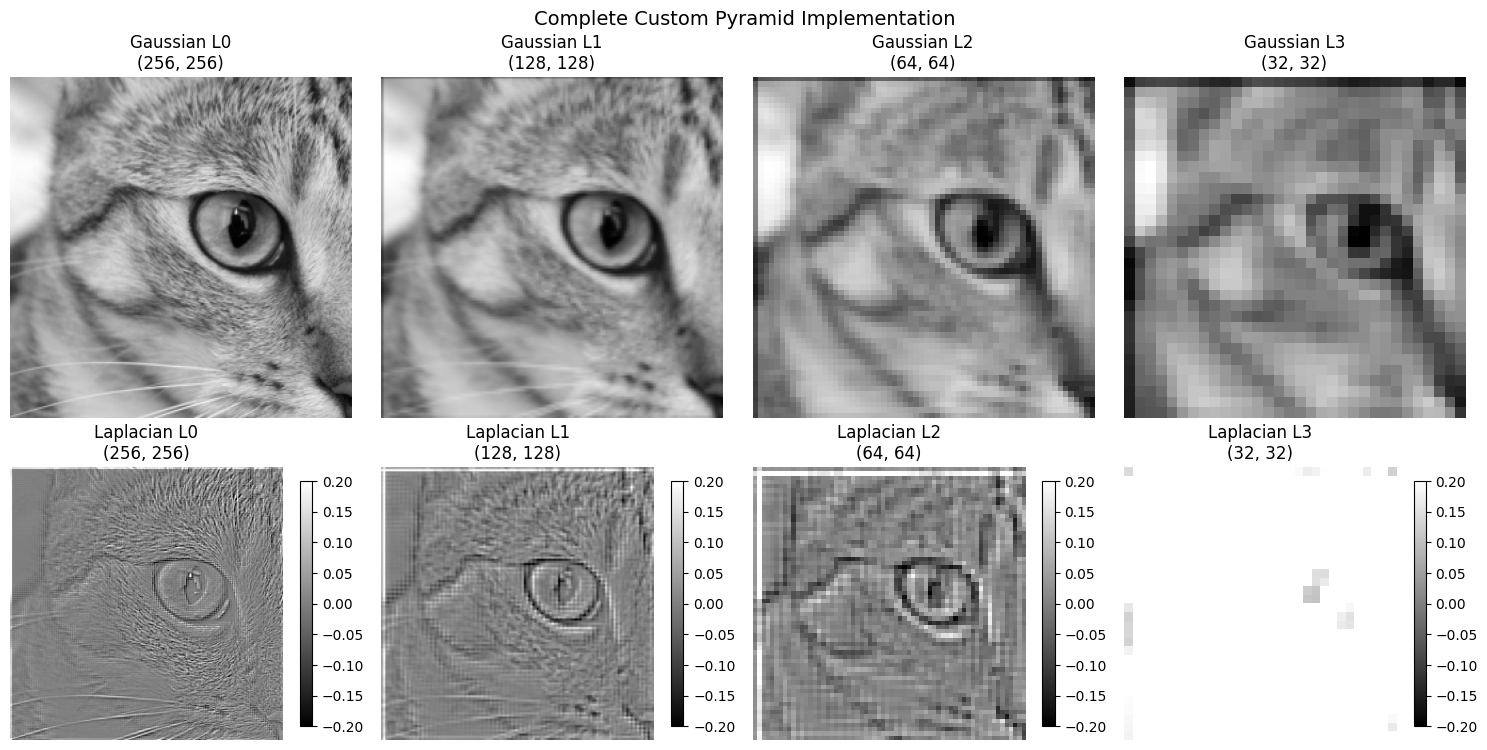

Library implementation reconstruction error: 0.00000000


In [25]:
def my_build_gaussian_pyramid(image, levels=4, sigma=1.0):
    """
    Build Gaussian pyramid using our custom functions.
    
    Args:
        image: 2D numpy array
        levels: number of pyramid levels
        sigma: Gaussian blur standard deviation
    
    Returns:
        gaussian_pyramid: list of images from finest to coarsest
    """
    pyramid = [image]
    current = image
    
    for i in range(1, levels):
        # Step 1: Apply Gaussian blur (anti-aliasing)
        blurred = my_gaussian_blur(current,sigma) # my_gaussian_blur()
        
        # Step 2: Downsample by factor of 2
        downsampled = my_downsample(blurred,factor=2) # my_downsample()
        
        pyramid.append(downsampled)
        current = downsampled
    
    return pyramid

def my_build_laplacian_pyramid(gaussian_pyr):
    """
    Build Laplacian pyramid from Gaussian pyramid.
    
    Args:
        gaussian_pyr: Gaussian pyramid from my_build_gaussian_pyramid
    
    Returns:
        laplacian_pyramid: list of detail images
    """
    laplacian_pyr = []
    
    # Process all levels except the top (coarsest) one
    for i in range(len(gaussian_pyr) - 1):
        current = gaussian_pyr[i]
        next_level = gaussian_pyr[i + 1]
        
        # Upsample the coarser level
        upsampled = my_upsample(next_level,current.shape,factor=2) # my_upsample()
        
        # Compute difference (detail)
        detail = current - upsampled
        laplacian_pyr.append(detail)
    
    # Top level is just the coarsest Gaussian
    laplacian_pyr.append(gaussian_pyr[-1])
    
    return laplacian_pyr

def my_reconstruct_from_laplacian(laplacian_pyr):
    """
    Reconstruct image from Laplacian pyramid.
    
    Args:
        laplacian_pyr: Laplacian pyramid from my_build_laplacian_pyramid
    
    Returns:
        reconstructed: reconstructed image
    """
    # Start with top (coarsest) level
    reconstructed = laplacian_pyr[-1]
    
    # Reconstruct from top to bottom
    for i in range(len(laplacian_pyr) - 2, -1, -1):
        # Upsample current reconstruction
        upsampled = my_upsample(reconstructed,laplacian_pyr[i].shape,factor=2) # my_upsample()
        # Add Laplacian detail
        reconstructed = upsampled+laplacian_pyr[i]
    
    return reconstructed

full_image = color.rgb2gray(data.chelsea())[:256, :256]  # Use smaller image for speed

print("Building Gaussian pyramid with custom functions...")
custom_gaussian = my_build_gaussian_pyramid(full_image, levels=4, sigma=1.0)

print("Building Laplacian pyramid with custom functions...")
custom_laplacian = my_build_laplacian_pyramid(custom_gaussian)

print("Reconstructing image...")
custom_reconstructed = my_reconstruct_from_laplacian(custom_laplacian)

# Calculate reconstruction error
reconstruction_error = np.mean(np.abs(full_image-custom_reconstructed))
print(f"Custom implementation reconstruction error: {reconstruction_error:.8f}")

# Visualize our custom pyramids
fig, axes = plt.subplots(2, 4, figsize=(15, 8))

# Show Gaussian pyramid
for i, level in enumerate(custom_gaussian):
    axes[0, i].imshow(level, cmap='gray')
    axes[0, i].set_title(f'Gaussian L{i}\n{level.shape}')
    axes[0, i].axis('off')

# Show Laplacian pyramid  
for i, level in enumerate(custom_laplacian):
    if i < 4:  # Detail levels
        im = axes[1, i].imshow(level, cmap='gray', vmin=-0.2, vmax=0.2)
        axes[1, i].set_title(f'Laplacian L{i}\n{level.shape}')
        axes[1, i].axis('off')
        plt.colorbar(im, ax=axes[1, i], shrink=0.7)
    else:  # Top level (Gaussian)
        axes[1, i].imshow(level, cmap='gray')
        axes[1, i].set_title(f'Top Gaussian L{i}\n{level.shape}')
        axes[1, i].axis('off')

# Hide unused subplots
for i in range(len(custom_laplacian), 4):
    axes[1, i].axis('off')

plt.suptitle('Complete Custom Pyramid Implementation', fontsize=14)
plt.tight_layout()
plt.show()

##################################################################################################

# from previous_sections import build_gaussian_pyramid, build_laplacian_pyramid, reconstruct_from_laplacian_pyramid

lib_gaussian = build_gaussian_pyramid(full_image, levels=4)
lib_laplacian = build_laplacian_pyramid(lib_gaussian)
lib_reconstructed = reconstruct_from_laplacian_pyramid(lib_laplacian)

lib_error = np.mean(np.abs(full_image-lib_reconstructed))
print(f"Library implementation reconstruction error: {lib_error:.8f}")


Implement the multiband blending algorithm using Laplacian pyramids to create seamless transitions between two images.


In [26]:
def multiband_blend(imageA, imageB, mask, levels=6):
    """
    Blend two images using Laplacian pyramid blending.
    
    Args:
        imageA: first image (numpy array)
        imageB: second image (numpy array) 
        mask: blend mask (0-1 values, same spatial dimensions as images)
        levels: number of pyramid levels
    
    Returns:
        blended: seamlessly blended image
        pyramids: dictionary containing all pyramids for visualization
    """
    # Ensure mask is 2D and has same spatial dimensions as images
    if mask.ndim == 3:
        mask = mask[:, :, 0]
    mask = transform.resize(mask, imageA.shape[:2], anti_aliasing=False)
    
    # Build Gaussian pyramids for both images and the mask
    GA = build_gaussian_pyramid(imageA, levels) # imageA
    GB = build_gaussian_pyramid(imageB, levels) # imageB
    GM = build_gaussian_pyramid(float(mask), levels) # mask
    
    # Build Laplacian pyramids for both images
    LA = build_laplacian_pyramid(GA)
    LB = build_laplacian_pyramid(GB)
    
    # Blend each level of the Laplacian pyramids using the Gaussian mask
    LS = []
    for i in range(levels):
        # Weighted combination: imageA * mask + imageB * (1-mask)
        # For Laplacian levels (detail), we use the corresponding Gaussian mask level
        if LA[i].ndim == 3:  # Color image
            blended_level = LA[i]*GM[i][..., None]+LB[i]*(1-GM[i][...,None])
        else:  # Grayscale
            blended_level = LA[i] * GM[i] + LB[i] * (1 - GM[i])
        LS.append(blended_level)
    
    # Reconstruct the final blended image from the blended Laplacian pyramid
    blended = reconstruct_from_laplacian_pyramid(LS)
    
    # Clip to valid range and return
    blended = np.clip(blended, 0, 1)
    
    pyramids = {
        'gaussian_A': GA, 'gaussian_B': GB, 'gaussian_mask': GM,
        'laplacian_A': LA, 'laplacian_B': LB, 'laplacian_blended': LS
    }
    
    return blended, pyramids

So far, we've explored spatial aliasing in still images. However, aliasing becomes even more fascinating and problematic when we deal with video - sequences of images over time. **Temporal aliasing** occurs when we sample a moving signal at too low a frame rate, causing fast-moving objects to appear to move at different speeds or even in the wrong direction! This is the reason why wagon wheels sometimes appear to spin backwards in movies (the "wagon-wheel effect") and why fast-moving objects can seem to stutter or disappear entirely.

Simulate and analyze temporal aliasing by downsampling video sequences and observing motion artifacts.


##### Create Video and Define Proper Downsampling


In [27]:
# Create moving video
base = data.camera()
n_frames = 18
frames = [np.roll(base, shift=i*10, axis=1) for i in range(n_frames)]

def downsample_spatial(frames, scale_factor):
    """Proper spatial downsampling with anti-aliasing."""
    return [transform.resize(frame,(int(frame.shape[0]*scale_factor), int(frame.shape[1]*scale_factor)),anti_aliasing=True)
            for frame in frames]

def downsample_temporal(frames, skip_factor):
    """Temporal downsampling by skipping frames."""
    return frames[::skip_factor]

# Test different downsampling strategies
scale_factors = [1.0, 0.5, 0.25]  # Spatial downsampling
skip_factors = [1, 3, 6]           # Temporal downsampling

- Spatial downsampling reduces resolution but maintains smooth motion
- Temporal downsampling maintains resolution but creates jerky motion


##### Compare Spatial vs Temporal Downsampling


SPATIAL Downsampling (resolution reduction):
Scale 1.0: (512, 512)
Scale 0.5: (256, 256)
Scale 0.25: (128, 128)

TEMPORAL Downsampling (frame rate reduction):
Skip 1: 18 frames
Skip 3: 6 frames
Skip 6: 3 frames


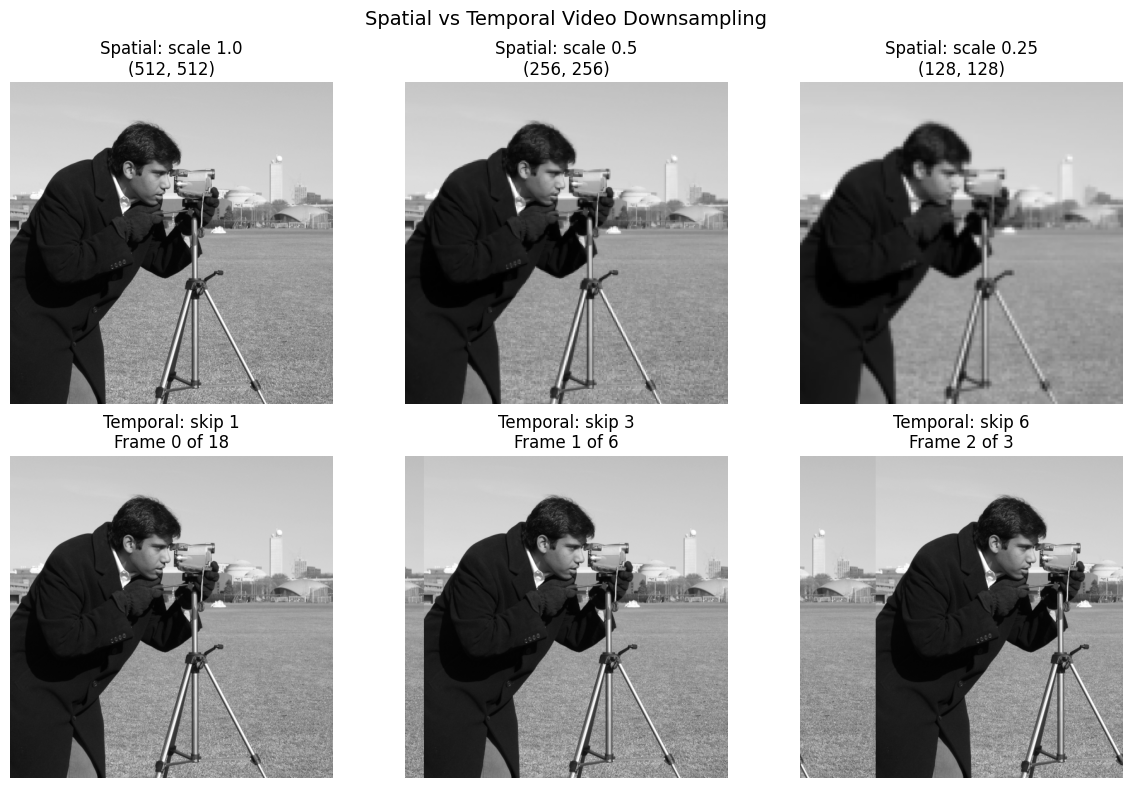

In [28]:
# Apply both types of downsampling
spatial_results = {}
temporal_results = {}

print("SPATIAL Downsampling (resolution reduction):")
for scale in scale_factors:
    down_frames = downsample_spatial(frames, scale)
    spatial_results[scale] = down_frames
    print(f"Scale {scale}: {down_frames[0].shape}")

print("\nTEMPORAL Downsampling (frame rate reduction):")  
for skip in skip_factors:
    down_frames = downsample_temporal(frames, skip)
    temporal_results[skip] = down_frames
    print(f"Skip {skip}: {len(down_frames)} frames")

# Visualize comparison
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Spatial downsampling examples
spatial_sample = [1.0, 0.5, 0.25]
for i, scale in enumerate(spatial_sample):
    frame = spatial_results[scale][0]  # First frame
    axes[0, i].imshow(frame, cmap='gray')
    axes[0, i].set_title(f'Spatial: scale {scale}\n{frame.shape}')
    axes[0, i].axis('off')

# Temporal downsampling examples  
temporal_sample = [1, 3, 6]
for i, skip in enumerate(temporal_sample):
    if i < len(temporal_results[skip]):
        frame = temporal_results[skip][i]
        axes[1, i].imshow(frame, cmap='gray')
        axes[1, i].set_title(f'Temporal: skip {skip}\nFrame {i} of {len(temporal_results[skip])}')
    axes[1, i].axis('off')

plt.suptitle('Spatial vs Temporal Video Downsampling', fontsize=14)
plt.tight_layout()
plt.show()

- Spatial: 100% $\rightarrow$ 50% $\rightarrow$ 25% resolution, but all 12 frames preserved
- Temporal: 12 frames $\rightarrow$ 4 frames $\rightarrow$ 2 frames, but full resolution maintained


##### Show Motion Artifacts


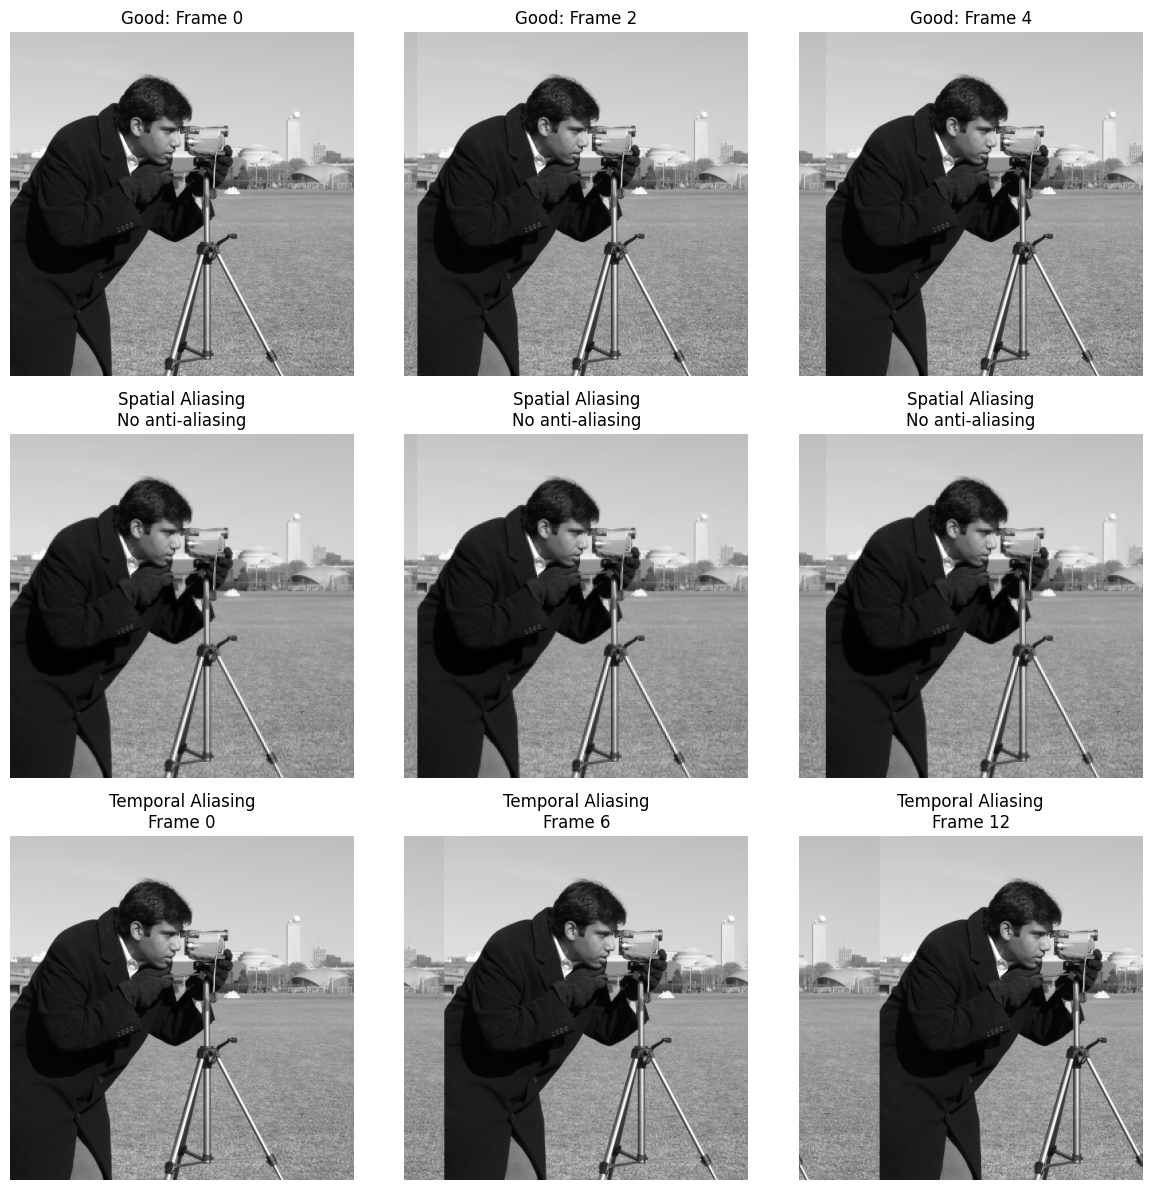

ARTIFACT ANALYSIS:
Row 1: Good quality - mild downsampling, proper anti-aliasing
Row 2: Spatial aliasing - jagged edges from no anti-aliasing filter
Row 3: Temporal aliasing - jerky motion from too few frames


In [29]:
# Compare motion quality
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Case 1: High quality (original)
case1_frames = frames[::2]  # Mild temporal downsampling
for i in range(3):
    if i < len(case1_frames):
        axes[0, i].imshow(case1_frames[i], cmap='gray')
        axes[0, i].set_title(f'Good: Frame {i*2}')
    axes[0, i].axis('off')

# Case 2: Spatial aliasing (no anti-aliasing)
case2_frames = [transform.resize(frame,(frame.shape[0]//2, frame.shape[1]//2),anti_aliasing=False) for frame in frames[::2]]  # No anti_aliasing!
for i in range(3):
    if i < len(case2_frames):
        axes[1, i].imshow(case2_frames[i], cmap='gray')
        axes[1, i].set_title(f'Spatial Aliasing\nNo anti-aliasing')
    axes[1, i].axis('off')

# Case 3: Temporal aliasing (severe frame skipping)  
case3_frames = frames[::6]  # Only 2 frames!
for i in range(3):
    if i < len(case3_frames):
        axes[2, i].imshow(case3_frames[i], cmap='gray')
        axes[2, i].set_title(f'Temporal Aliasing\nFrame {i*6}')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

print("ARTIFACT ANALYSIS:")
print("Row 1: Good quality - mild downsampling, proper anti-aliasing")
print("Row 2: Spatial aliasing - jagged edges from no anti-aliasing filter") 
print("Row 3: Temporal aliasing - jerky motion from too few frames")

- Spatial aliasing: Jagged edges from insufficient pre-filtering before resolution reduction
- Temporal aliasing: Jerky motion from insufficient frame rate for the motion speed


##### Proper Video Downsampling


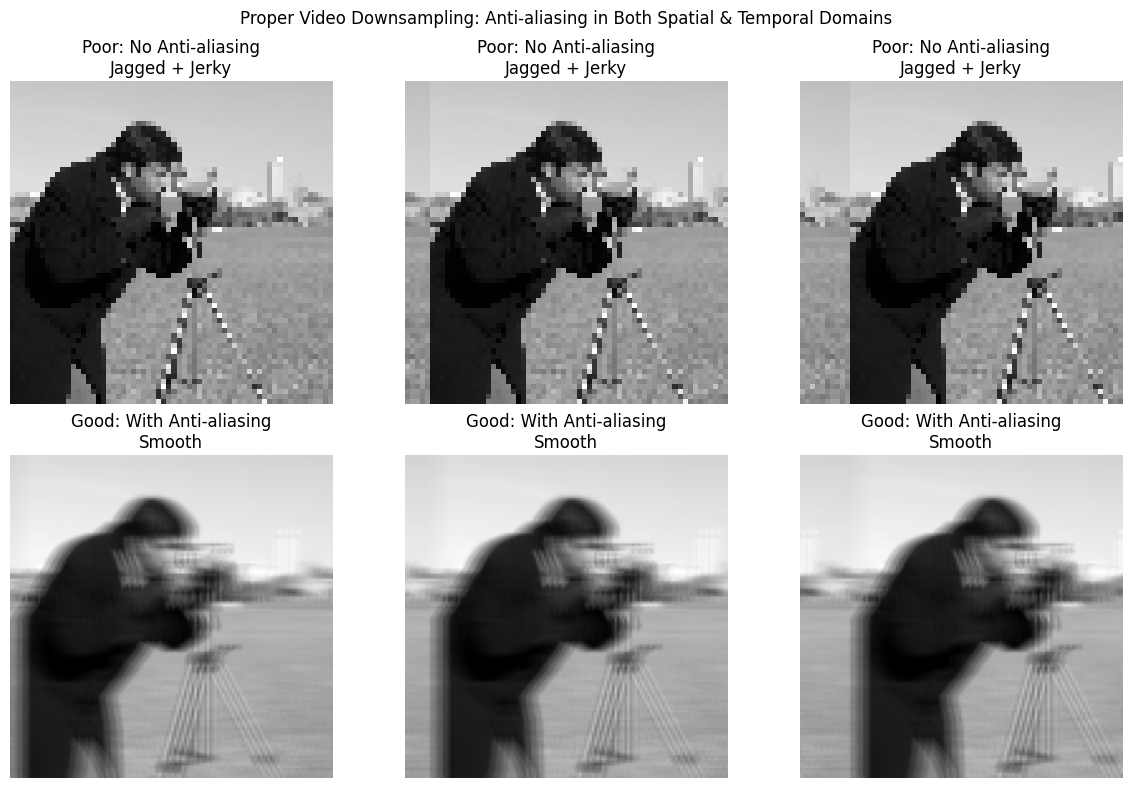

In [30]:
def proper_video_downsample(frames, spatial_scale, temporal_skip):
    """Proper video downsampling with anti-aliasing in both domains."""
    # First: temporal anti-aliasing (motion blur)
    temp_aa_frames = []
    for i in range(0, len(frames), temporal_skip):
        end_idx = min(i + temporal_skip, len(frames))
        blended = np.mean(frames[i:end_idx], axis=0)  # Motion blur
        temp_aa_frames.append(blended)
    
    # Then: spatial downsampling with anti-aliasing
    spatial_down_frames = []
    for frame in temp_aa_frames:
        down_frame = transform.resize(frame, (int(spatial_scale*frame.shape[0]), int(spatial_scale*frame.shape[1])),anti_aliasing=True)
        spatial_down_frames.append(down_frame)
    
    return spatial_down_frames

# Compare proper vs poor downsampling
poor_result = [transform.resize(frame, (64, 64), anti_aliasing=False) 
               for frame in frames[::4]]  # No anti-aliasing + frame skipping

good_result = proper_video_downsample(frames, spatial_scale=0.25, temporal_skip=4)

# Visualize quality difference
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i in range(3):
    if i < len(poor_result):
        axes[0, i].imshow(poor_result[i], cmap='gray')
        axes[0, i].set_title('Poor: No Anti-aliasing\nJagged + Jerky')
    axes[0, i].axis('off')
    
for i in range(3):
    if i < len(good_result):
        axes[1, i].imshow(good_result[i], cmap='gray')  
        axes[1, i].set_title('Good: With Anti-aliasing\nSmooth')
    axes[1, i].axis('off')

plt.suptitle('Proper Video Downsampling: Anti-aliasing in Both Spatial & Temporal Domains', fontsize=12)
plt.tight_layout()
plt.show()

- Temporal anti-aliasing: Motion blur before frame reduction
- Spatial anti-aliasing: Low-pass filter before resolution reduction
- Order matters: Do temporal AA first, then spatial AA
